# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from tqdm import tqdm
import os

C:\Users\Neelu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
# we are forming a dataset with 100000 points
filtered_data=filtered_data.sample(n=100000, random_state=1)

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(86847, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.847

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(86846, 10)


1    73352
0    13494
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

The same author wrote "Where the Wild Things Are."  Carol King wrote a great song that matches all the lyrics.  The illustrations are fabulous.  I wish I could buy it hardbound and larger.  It is a tiny book and easily misplaced.  My 3 year-old carries it everywhere.
it's definitely, especially being 4 down from the hottest on the list.  flavor is good too.  mainly used on tamales over the holiday and was very good.  couldn't use too much, as it was definitely a mouth burner.
Blueberry is a difficult flavor to find and if you do ... it may have an artificial aftertaste. Not the case with this product. Thank Goodness! We had a bridal shower and the theme was Nature's Garden. The dram size bottle made 10 dozen, blueberry, mini cupcakes with blueberry frosting. So yummy!
This basket was purchased as a gift for a grieving family. I'm sure the basket was beautiful although we did not see it ourselves. I paid for expedited delivery so that it could be received within days of the funeral. How

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

The same author wrote "Where the Wild Things Are."  Carol King wrote a great song that matches all the lyrics.  The illustrations are fabulous.  I wish I could buy it hardbound and larger.  It is a tiny book and easily misplaced.  My 3 year-old carries it everywhere.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

The same author wrote "Where the Wild Things Are."  Carol King wrote a great song that matches all the lyrics.  The illustrations are fabulous.  I wish I could buy it hardbound and larger.  It is a tiny book and easily misplaced.  My 3 year-old carries it everywhere.
it's definitely, especially being 4 down from the hottest on the list.  flavor is good too.  mainly used on tamales over the holiday and was very good.  couldn't use too much, as it was definitely a mouth burner.
Blueberry is a difficult flavor to find and if you do ... it may have an artificial aftertaste. Not the case with this product. Thank Goodness! We had a bridal shower and the theme was Nature's Garden. The dram size bottle made 10 dozen, blueberry, mini cupcakes with blueberry frosting. So yummy!
This basket was purchased as a gift for a grieving family. I'm sure the basket was beautiful although we did not see it ourselves. I paid for expedited delivery so that it could be received within days of the funeral. How

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Blueberry is a difficult flavor to find and if you do ... it may have an artificial aftertaste. Not the case with this product. Thank Goodness! We had a bridal shower and the theme was Nature is Garden. The dram size bottle made 10 dozen, blueberry, mini cupcakes with blueberry frosting. So yummy!


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

The same author wrote "Where the Wild Things Are."  Carol King wrote a great song that matches all the lyrics.  The illustrations are fabulous.  I wish I could buy it hardbound and larger.  It is a tiny book and easily misplaced.  My  year-old carries it everywhere.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Blueberry is a difficult flavor to find and if you do it may have an artificial aftertaste Not the case with this product Thank Goodness We had a bridal shower and the theme was Nature is Garden The dram size bottle made 10 dozen blueberry mini cupcakes with blueberry frosting So yummy 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████| 86846/86846 [03:54<00:00, 369.64it/s]


In [24]:
preprocessed_reviews[1500]

'blueberry difficult flavor find may artificial aftertaste not case product thank goodness bridal shower theme nature garden dram size bottle made dozen blueberry mini cupcakes blueberry frosting yummy'

In [25]:
score=final['Score'].values

In [26]:
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, score, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

In [27]:
## Similartly you can do preprocessing for review summary also.
# CODE FOR THE CONSTRUCTION OF CONFUSION MATRIX
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    
    labels = [0,1]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
   
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
count_vect = CountVectorizer() 
bag_counts = count_vect.fit_transform(X_tr)
testvalues=count_vect.transform(X_test)
cvvalues=count_vect.transform(X_cv)

## [4.3] TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer()
train_tfidf_text = tf_idf_vect.fit_transform(X_tr)
cv_tfidf_text=tf_idf_vect.transform(X_cv)
test_tfidf_text=tf_idf_vect.transform(X_test)

## [4.4] Word2Vec

In [55]:
# Train your own Word2Vec model using your own text corpus for RBF kernal train data
i=0
list_of_sentance=[]
list_of_sentance_cv=[]
list_of_sentance_test=[]
for sentance in X_tr:
    list_of_sentance.append(sentance.split())
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())


In [56]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8511797785758972), ('excellent', 0.8064351081848145), ('fantastic', 0.8016114234924316), ('good', 0.7867906093597412), ('terrific', 0.7587160468101501), ('wonderful', 0.7448478937149048), ('perfect', 0.7444790601730347), ('amazing', 0.7131214141845703), ('fabulous', 0.667978048324585), ('decent', 0.6672545671463013)]
[('best', 0.7782819867134094), ('closest', 0.7026782035827637), ('yummiest', 0.6685149669647217), ('disgusting', 0.66385817527771), ('weakest', 0.6545488238334656), ('tastiest', 0.6502605676651001), ('greatest', 0.6411856412887573), ('nastiest', 0.6346880197525024), ('smoothest', 0.6137202978134155), ('strangest', 0.6122117042541504)]


In [57]:
w2v_words = list(w2v_model.wv.vocab) ##for linear kernal
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12743
sample words  ['used', 'get', 'honey', 'bunches', 'oats', 'almonds', 'like', 'one', 'step', 'ahead', 'idea', 'fruit', 'cereal', 'would', 'definitely', 'buy', 'well', 'recommend', 'others', 'try', 'really', 'flavor', 'tea', 'first', 'tried', 'gift', 'basket', 'liked', 'went', 'online', 'find', 'bought', 'almost', 'cross', 'english', 'breakfast', 'earl', 'grey', 'buying', 'bread', 'mix', 'year', 'good', 'taste', 'texture', 'introduced', 'nieces', 'wheat', 'allergies', 'also']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [58]:
# average Word2Vec for linear
# compute average word2vec of each review for linear svm train data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 42554/42554 [04:32<00:00, 156.32it/s]


42554
50


In [59]:
# average Word2Vec for linear
# compute average word2vec of each review for linear kernal cv data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████| 18238/18238 [01:58<00:00, 154.02it/s]


18238
50


In [60]:
# average Word2Vec for linear
# compute average word2vec of each review for linear kernal test data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████| 26054/26054 [02:46<00:00, 156.70it/s]


26054
50


#### [4.4.1.2] TFIDF weighted W2v

In [61]:
# Tfidf word to vec model training for linear svm
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [62]:
# TF-IDF weighted Word2Vec training for  linear keranl train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

100%|██████████████████████████████████| 42554/42554 [4:14:21<00:00,  9.32it/s]


In [63]:
# TF-IDF weighted Word2Vec  training for linear keranl cv data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 18238/18238 [36:18<00:00, 10.77it/s]


In [64]:
# TF-IDF weighted Word2Vec  training for linear keranl test data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 26054/26054 [58:08<00:00,  7.47it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.9288 0.9264 0.895  0.78   0.6471 0.5    0.5    0.5    0.5   ]
the auc score for cv data for each alpha value is :  [0.9131 0.9096 0.8845 0.777  0.6426 0.5    0.5    0.5    0.5   ]

The optimal alpha is. 1e-05


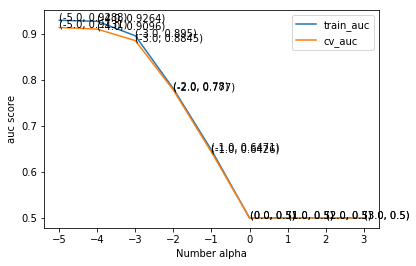

For values of best alpha =  1e-05 The train auc is: 97.55761992312424
For values of best alpha =  1e-05 The cross validation auc is: 92.67831520800826
For values of best alpha =  1e-05 The test  auc is: 93.02167233076653


In [29]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_1 =  SGDClassifier( class_weight='balanced', alpha=i, penalty='l1', loss='log', random_state=42)
    clf_1.fit(bag_counts,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_1, method="sigmoid")
    sig_clf.fit(bag_counts, y_tr)
    scores_train = cross_val_score(sig_clf, bag_counts, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, cvvalues, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
    
    
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


best_alpha = optimal_alpha
clf_1= SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l1', loss='log', random_state=42)### training the model with the best alpha value
clf_1.fit(bag_counts, y_tr)
sig_clf = CalibratedClassifierCV(clf_1, method="sigmoid")
sig_clf.fit(bag_counts, y_tr)


predict_y = sig_clf.predict_proba(bag_counts)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(cvvalues)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(testvalues)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# Confusion matrix for test values

-------------------- Confusion matrix --------------------


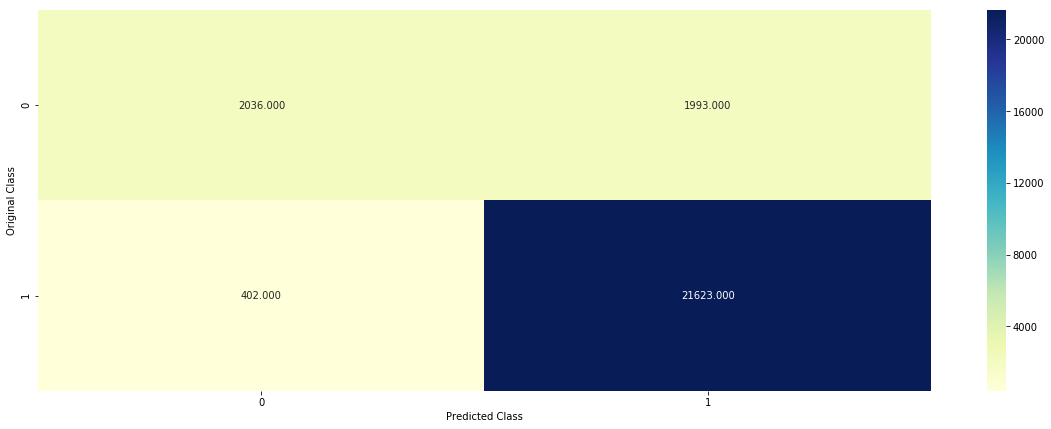

-------------------- Precision matrix (Columm Sum=1) --------------------


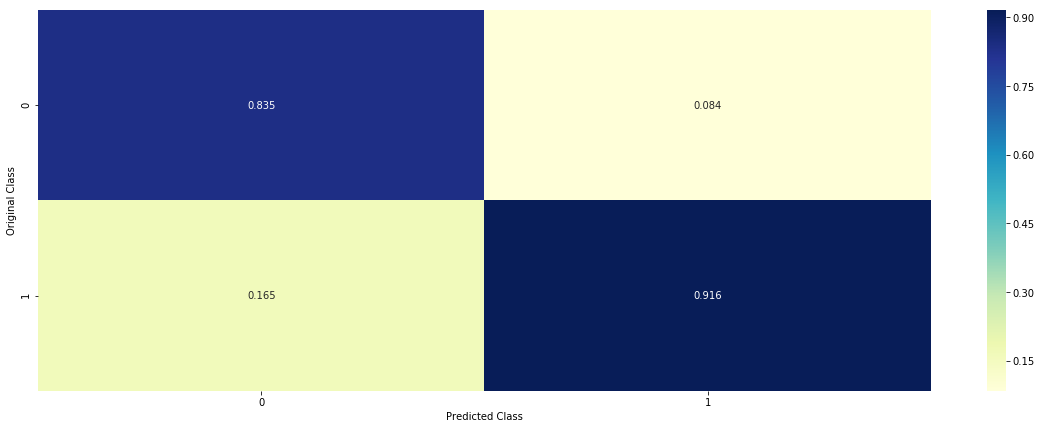

-------------------- Recall matrix (Row sum=1) --------------------


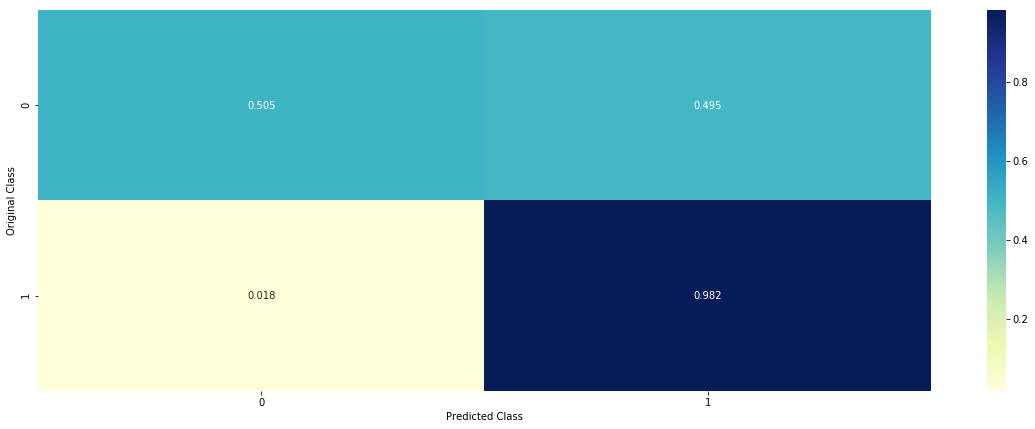

In [32]:
predict_y = sig_clf.predict(testvalues)
plot_confusion_matrix(y_test, predict_y)

# Confusion matrix for cv values

-------------------- Confusion matrix --------------------


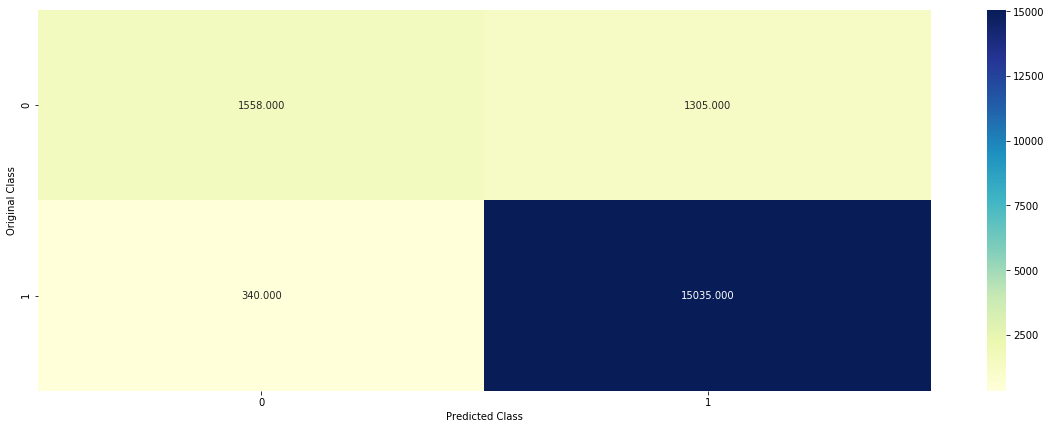

-------------------- Precision matrix (Columm Sum=1) --------------------


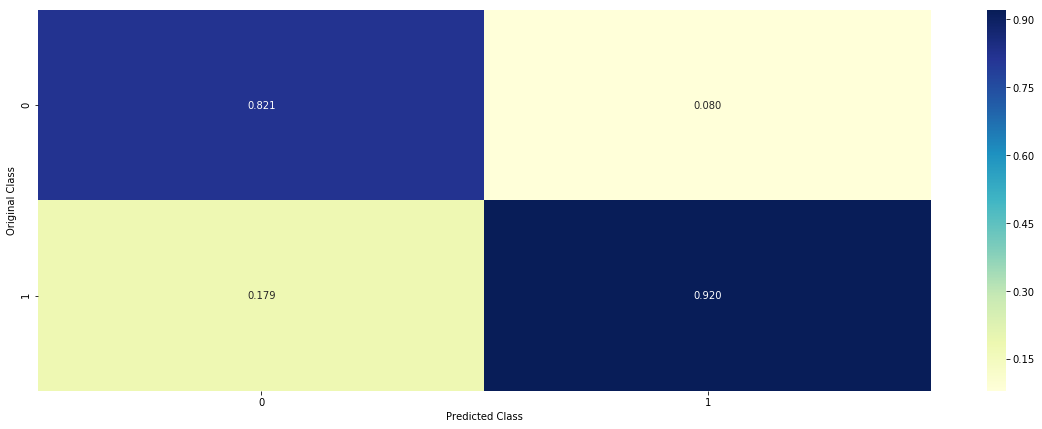

-------------------- Recall matrix (Row sum=1) --------------------


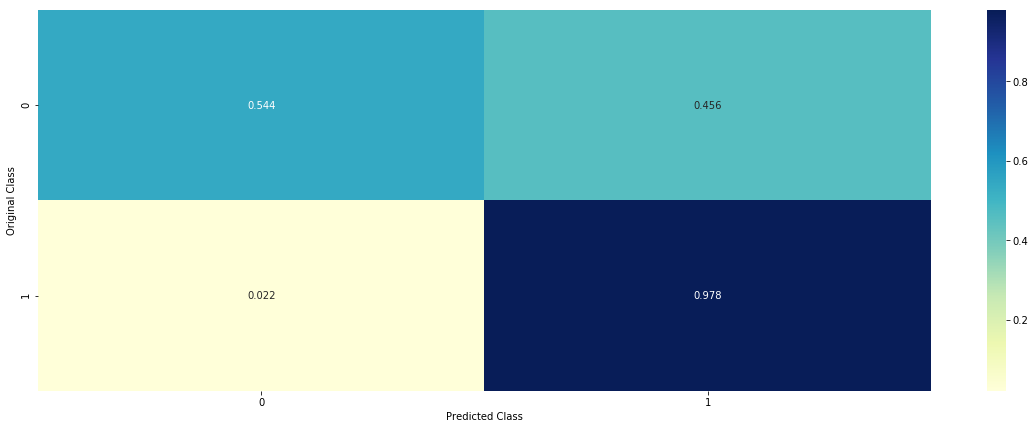

In [67]:
predict_y = sig_clf.predict_proba(cvvalues)
plot_confusion_matrix(y_cv, predict_y)

# ROC curve for train and test data 

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l1', loss='log', random_state=42)### training the model with the best alpha value
clf.fit(bag_counts, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(bag_counts, y_tr)


predict_y_train = sig_clf.predict(bag_counts)
predict_y_test = sig_clf.predict(testvalues)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


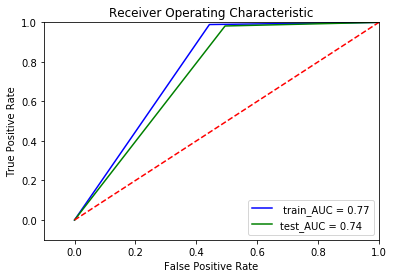

In [36]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l1', loss='log', random_state=42)### training the model with the best alpha value
clf.fit(bag_counts, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(bag_counts, y_tr)


predict_y_train = sig_clf.predict(bag_counts)
predict_y_test = sig_clf.predict(testvalues)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [122]:
# Please write all the code with proper documentation
sparse_w=clf_1.coef_## getting the coefficients of l1 regularised logistic regreesion
non_zero=np.count_nonzero(sparse_w)  
print( 'the number of non-zero coefficients are :',non_zero)

the number of non-zero coefficients are : 15028


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.9258 0.9288 0.9379 0.9204 0.8762 0.8135 0.7627 0.752  0.7507]
the auc score for cv data for each alpha value is :  [0.911  0.9117 0.9233 0.9067 0.8602 0.7974 0.7523 0.7436 0.7427]

The optimal alpha is. 0.001


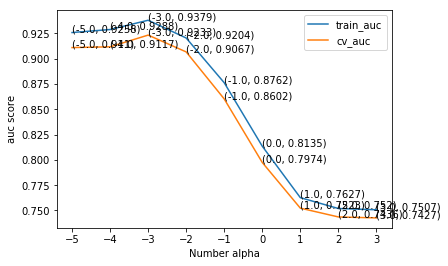

For values of best alpha =  0.001 The train auc is: 97.05095587791241
For values of best alpha =  0.001 The cross validation auc is: 93.2845099976638
For values of best alpha =  0.001 The test  auc is: 93.73980412722855


In [39]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf2 =  SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf2.fit(bag_counts,  y_tr)
    sig_clf_bow = CalibratedClassifierCV(clf2, method="sigmoid")
    sig_clf_bow.fit(bag_counts, y_tr)
    scores_train = cross_val_score(sig_clf_bow, bag_counts, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf_bow, cvvalues, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
    
    
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


best_alpha = optimal_alpha
clf2= SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)### training the model with the best alpha value
clf2.fit(bag_counts, y_tr)
sig_clf_bow = CalibratedClassifierCV(clf2, method="sigmoid")
sig_clf_bow.fit(bag_counts, y_tr)


predict_y = sig_clf_bow.predict_proba(bag_counts)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf_bow.predict_proba(cvvalues)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf_bow.predict_proba(testvalues)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# ROC curve for train and test data 

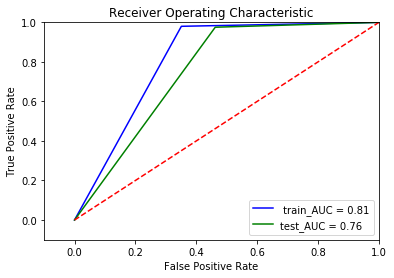

In [35]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)### training the model with the best alpha value
clf.fit(bag_counts, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(bag_counts, y_tr)


predict_y_train = sig_clf.predict(bag_counts)
predict_y_test = sig_clf.predict(testvalues)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Confusion matrix for test values

In [36]:
predict_y = sig_clf_bow.predict_proba(testvalues)
plot_confusion_matrix(y_test, predict_y)

NameError: name 'sig_clf_bow' is not defined

# Confusion matrix for cv values

In [37]:
predict_y = sig_clf_bow.predict_proba(cvvalues)
plot_confusion_matrix(y_cv, predict_y)

NameError: name 'sig_clf_bow' is not defined

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.9258 0.9288 0.9379 0.9204 0.8762 0.8135 0.7627 0.752  0.7507]
the auc score for cv data for each alpha value is :  [0.911  0.9117 0.9233 0.9067 0.8602 0.7974 0.7523 0.7436 0.7427]

The optimal alpha is. 0.001


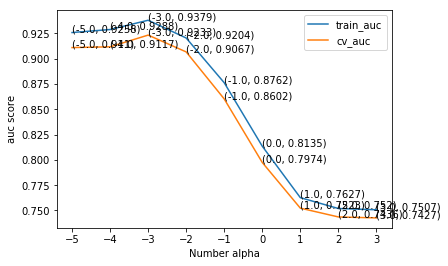

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

In [32]:
# Please write all the code with proper documentation
#bag_counts_pertubation=np.empty((bag_counts.shape))
mu, sigma = 0, 0.11 # mean and standard deviation
s = np.random.normal(mu, sigma)
bag_counts.data=bag_counts.data+s ##adding data to the initial values
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_change =  SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf_change.fit(bag_counts,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_change, method="sigmoid")
    sig_clf.fit(bag_counts, y_tr)
    scores_train = cross_val_score(sig_clf, bag_counts, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, cvvalues, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
    
    
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()

best_alpha = optimal_alpha
clf_change= SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)### training the model with the best alpha value
clf_change.fit(bag_counts, y_tr)
sig_clf = CalibratedClassifierCV(clf_change, method="sigmoid")
sig_clf.fit(bag_counts, y_tr)



In [121]:
##Calculating the percentage change after adding noise

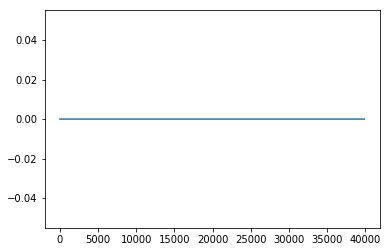

In [40]:

w=clf2.coef_ ## 

w1=clf_change.coef_
features=count_vect.get_feature_names()
x=w.ravel() ## w is the weights before adding nosie
a=x.tolist()
y=w1.ravel()## w1 is the weights after adding noise
b=y.tolist()
a=[x+0.0000001 for x in a]
b=[x+0.0000001 for x in b]
percent=(list(abs(abs(np.array(a) - np.array(b))*100)))## finding the percentage change
lk=sorted(percent,reverse=True)
plt.plot(lk)
plt.show()

From the above graph we can say that the first 5000 features are multicollinear

# Displaying the multicollinear features

In [41]:
topfeatures=sorted(zip(percent, features),reverse=True)[:5000]
for coef,features in topfeatures:
    print("value : %d   feature: %s" %(coef,features))

value : 0   feature: zzzzzz
value : 0   feature: zyrtec
value : 0   feature: zx
value : 0   feature: zveet
value : 0   feature: zumba
value : 0   feature: zulu
value : 0   feature: zukes
value : 0   feature: zuke
value : 0   feature: zuk
value : 0   feature: zuchon
value : 0   feature: zucchinis
value : 0   feature: zucchini
value : 0   feature: zuc
value : 0   feature: zsweet
value : 0   feature: zsa
value : 0   feature: zotz
value : 0   feature: zots
value : 0   feature: zooplankton
value : 0   feature: zooohhhh
value : 0   feature: zoomies
value : 0   feature: zoomed
value : 0   feature: zoom
value : 0   feature: zoo
value : 0   feature: zoning
value : 0   feature: zones
value : 0   feature: zone
value : 0   feature: zon
value : 0   feature: zombies
value : 0   feature: zombie
value : 0   feature: zola
value : 0   feature: zojirushi
value : 0   feature: zoe
value : 0   feature: znaturalfoods
value : 0   feature: ziwipeak
value : 0   feature: ziwi
value : 0   feature: zito
value : 0 

value : 0   feature: yoda
value : 0   feature: yo
value : 0   feature: ymmv
value : 0   feature: ymmmmmmmmmmmmm
value : 0   feature: ymmmmm
value : 0   feature: ymca
value : 0   feature: yleck
value : 0   feature: yku
value : 0   feature: yiu
value : 0   feature: yirgacheffe
value : 0   feature: yiragacheffe
value : 0   feature: yips
value : 0   feature: yippie
value : 0   feature: yippee
value : 0   feature: yipee
value : 0   feature: ying
value : 0   feature: yin
value : 0   feature: yikes
value : 0   feature: yields
value : 0   feature: yielding
value : 0   feature: yielded
value : 0   feature: yield
value : 0   feature: yi
value : 0   feature: yhese
value : 0   feature: yever
value : 0   feature: yeucks
value : 0   feature: yet
value : 0   feature: yeswhiskas
value : 0   feature: yesteryear
value : 0   feature: yesterdayand
value : 0   feature: yesterday
value : 0   feature: yessiree
value : 0   feature: yes
value : 0   feature: yerbe
value : 0   feature: yerba
value : 0   feature:

value : 0   feature: wouldouble
value : 0   feature: wouldoorstep
value : 0   feature: wouldonut
value : 0   feature: wouldog
value : 0   feature: wouldoctor
value : 0   feature: wouldnt
value : 0   feature: wouldnot
value : 0   feature: wouldissolved
value : 0   feature: wouldissolve
value : 0   feature: wouldiscovery
value : 0   feature: wouldiscovered
value : 0   feature: wouldirty
value : 0   feature: wouldirections
value : 0   feature: wouldirect
value : 0   feature: wouldimagine
value : 0   feature: wouldiet
value : 0   feature: wouldessert
value : 0   feature: wouldente
value : 0   feature: wouldense
value : 0   feature: wouldedicated
value : 0   feature: wouldecoder
value : 0   feature: wouldecaffeinated
value : 0   feature: wouldecaf
value : 0   feature: woulddefintely
value : 0   feature: wouldbe
value : 0   feature: woulday
value : 0   feature: wouldate
value : 0   feature: wouldash
value : 0   feature: wouldark
value : 0   feature: wouldaily
value : 0   feature: woulda
valu

value : 0   feature: wired
value : 0   feature: wire
value : 0   feature: wipping
value : 0   feature: wiping
value : 0   feature: wipes
value : 0   feature: wiped
value : 0   feature: wipe
value : 0   feature: wip
value : 0   feature: winy
value : 0   feature: wintry
value : 0   feature: wintogreen
value : 0   feature: wintery
value : 0   feature: wintertime
value : 0   feature: winters
value : 0   feature: wintermints
value : 0   feature: wintermint
value : 0   feature: wintergreen
value : 0   feature: winterfrost
value : 0   feature: winterfresh
value : 0   feature: winter
value : 0   feature: winston
value : 0   feature: winslow
value : 0   feature: wins
value : 0   feature: winonna
value : 0   feature: winona
value : 0   feature: wino
value : 0   feature: winnowing
value : 0   feature: winnings
value : 0   feature: winning
value : 0   feature: winnie
value : 0   feature: winners
value : 0   feature: winner
value : 0   feature: winna
value : 0   feature: winn
value : 0   feature: w

value : 0   feature: whenwe
value : 0   feature: whenver
value : 0   feature: whentime
value : 0   feature: whenthey
value : 0   feature: whenit
value : 0   feature: wheni
value : 0   feature: whenever
value : 0   feature: whelmingly
value : 0   feature: wheezy
value : 0   feature: wheezing
value : 0   feature: wheels
value : 0   feature: wheeler
value : 0   feature: wheelchair
value : 0   feature: wheel
value : 0   feature: wheeeeew
value : 0   feature: wheaty
value : 0   feature: wheats
value : 0   feature: wheatmeal
value : 0   feature: wheaties
value : 0   feature: wheather
value : 0   feature: wheatgrass
value : 0   feature: wheatgerm
value : 0   feature: wheatens
value : 0   feature: wheatena
value : 0   feature: wheaten
value : 0   feature: wheat
value : 0   feature: whe
value : 0   feature: whatsup
value : 0   feature: whatsover
value : 0   feature: whatsoever
value : 0   feature: whats
value : 0   feature: whatpro
value : 0   feature: whatnot
value : 0   feature: whatflavor
va

value : 0   feature: watermelonpomegranate
value : 0   feature: watermelonblack
value : 0   feature: watermelon
value : 0   feature: watermelmon
value : 0   feature: watermellon
value : 0   feature: watermark
value : 0   feature: waterly
value : 0   feature: waterloo
value : 0   feature: wateris
value : 0   feature: wateringly
value : 0   feature: watering
value : 0   feature: waterfowl
value : 0   feature: watered
value : 0   feature: watercress
value : 0   feature: watercorn
value : 0   feature: watercombine
value : 0   feature: watercolor
value : 0   feature: waterbury
value : 0   feature: waterbug
value : 0   feature: waterbelt
value : 0   feature: watera
value : 0   feature: water
value : 0   feature: watchword
value : 0   feature: watchingsome
value : 0   feature: watching
value : 0   feature: watchin
value : 0   feature: watches
value : 0   feature: watchers
value : 0   feature: watcher
value : 0   feature: watched
value : 0   feature: watchdog
value : 0   feature: watch
value :

value : 0   feature: vorum
value : 0   feature: voraciously
value : 0   feature: voracious
value : 0   feature: voortman
value : 0   feature: voodoo
value : 0   feature: vons
value : 0   feature: von
value : 0   feature: vomitting
value : 0   feature: vomitted
value : 0   feature: vomits
value : 0   feature: vomiting
value : 0   feature: vomited
value : 0   feature: vomit
value : 0   feature: volvo
value : 0   feature: voluptuous
value : 0   feature: voluptuoso
value : 0   feature: voluntered
value : 0   feature: volunteers
value : 0   feature: volunteered
value : 0   feature: volunteer
value : 0   feature: voluntary
value : 0   feature: voluntarily
value : 0   feature: volumn
value : 0   feature: volumizing
value : 0   feature: volumizer
value : 0   feature: volumize
value : 0   feature: voluminous
value : 0   feature: volumes
value : 0   feature: volume
value : 0   feature: volts
value : 0   feature: volt
value : 0   feature: volont
value : 0   feature: vollkornbrot
value : 0   featu

value : 0   feature: verve
value : 0   feature: vertigo
value : 0   feature: vertically
value : 0   feature: vertical
value : 0   feature: vertebre
value : 0   feature: versus
value : 0   feature: versitle
value : 0   feature: versitile
value : 0   feature: versital
value : 0   feature: versionwith
value : 0   feature: versionsto
value : 0   feature: versions
value : 0   feature: versionanyway
value : 0   feature: version
value : 0   feature: versicolor
value : 0   feature: verses
value : 0   feature: versed
value : 0   feature: verse
value : 0   feature: versatilityif
value : 0   feature: versatility
value : 0   feature: versatile
value : 0   feature: versa
value : 0   feature: verry
value : 0   feature: verrry
value : 0   feature: verrrry
value : 0   feature: verrefreshing
value : 0   feature: veronastarbucks
value : 0   feature: veronaif
value : 0   feature: verona
value : 0   feature: vero
value : 0   feature: vernors
value : 0   feature: vernor
value : 0   feature: vernacular
valu

value : 0   feature: vacuums
value : 0   feature: vacuuming
value : 0   feature: vacuumed
value : 0   feature: vacuum
value : 0   feature: vacume
value : 0   feature: vacum
value : 0   feature: vaction
value : 0   feature: vacillate
value : 0   feature: vaccuum
value : 0   feature: vaccum
value : 0   feature: vaccines
value : 0   feature: vaccination
value : 0   feature: vacations
value : 0   feature: vacationing
value : 0   feature: vacationed
value : 0   feature: vacation
value : 0   feature: vac
value : 0   feature: vabeachwholesale
value : 0   feature: va
value : 0   feature: uwajimaya
value : 0   feature: uva
value : 0   feature: uv
value : 0   feature: uuu
value : 0   feature: utz
value : 0   feature: utube
value : 0   feature: utterly
value : 0   feature: uttered
value : 0   feature: utter
value : 0   feature: utmost
value : 0   feature: utis
value : 0   feature: utilizing
value : 0   feature: utilizes
value : 0   feature: utilized
value : 0   feature: utilize
value : 0   featur

value : 0   feature: unemployment
value : 0   feature: unemployed
value : 0   feature: unecesary
value : 0   feature: uneatten
value : 0   feature: uneaten
value : 0   feature: uneatable
value : 0   feature: uneasy
value : 0   feature: undying
value : 0   feature: undue
value : 0   feature: undrinkable
value : 0   feature: undoubtedly
value : 0   feature: undoubtably
value : 0   feature: undone
value : 0   feature: undon
value : 0   feature: undoing
value : 0   feature: undoes
value : 0   feature: undivided
value : 0   feature: undisturbed
value : 0   feature: undistinguishable
value : 0   feature: undissolved
value : 0   feature: undisputed
value : 0   feature: undisputably
value : 0   feature: undiscriminating
value : 0   feature: undiscovered
value : 0   feature: undisclosed
value : 0   feature: undiluted
value : 0   feature: undigestible
value : 0   feature: undigested
value : 0   feature: undiagnosed
value : 0   feature: undeveloped
value : 0   feature: undeterred
value : 0   feat

value : 0   feature: ufos
value : 0   feature: ufo
value : 0   feature: ufc
value : 0   feature: ue
value : 0   feature: udon
value : 0   feature: udo
value : 0   feature: udnerlying
value : 0   feature: udis
value : 0   feature: udi
value : 0   feature: uddate
value : 0   feature: udda
value : 0   feature: udad
value : 0   feature: ucky
value : 0   feature: uc
value : 0   feature: ubiquitously
value : 0   feature: ubiquitous
value : 0   feature: ubet
value : 0   feature: uber
value : 0   feature: uaually
value : 0   feature: tzus
value : 0   feature: tzu
value : 0   feature: tzao
value : 0   feature: tyrosine
value : 0   feature: tyrophile
value : 0   feature: tyrkisk
value : 0   feature: tyrant
value : 0   feature: tyranny
value : 0   feature: tyranasaurus
value : 0   feature: typo
value : 0   feature: typing
value : 0   feature: typically
value : 0   feature: typical
value : 0   feature: typhoo
value : 0   feature: types
value : 0   feature: typeo
value : 0   feature: typee
value : 

value : 0   feature: truelemon
value : 0   feature: true
value : 0   feature: trudi
value : 0   feature: trucks
value : 0   feature: truckloads
value : 0   feature: trucking
value : 0   feature: trucker
value : 0   feature: trucked
value : 0   feature: truck
value : 0   feature: tru
value : 0   feature: trout
value : 0   feature: trousers
value : 0   feature: trough
value : 0   feature: troubling
value : 0   feature: troublesome
value : 0   feature: troubleshooting
value : 0   feature: troubles
value : 0   feature: troublefinding
value : 0   feature: troubled
value : 0   feature: trouble
value : 0   feature: trotter
value : 0   feature: trotted
value : 0   feature: trots
value : 0   feature: tropics
value : 0   feature: tropicana
value : 0   feature: tropicals
value : 0   feature: tropical
value : 0   feature: tropic
value : 0   feature: tropi
value : 0   feature: trophycase
value : 0   feature: trophy
value : 0   feature: troops
value : 0   feature: trooper
value : 0   feature: trompi

value : 0   feature: tonighti
value : 0   feature: tonight
value : 0   feature: tonics
value : 0   feature: tonic
value : 0   feature: tongues
value : 0   feature: tongueput
value : 0   feature: tongueless
value : 0   feature: tongue
value : 0   feature: tongs
value : 0   feature: tongkat
value : 0   feature: tones
value : 0   feature: toner
value : 0   feature: toned
value : 0   feature: tone
value : 0   feature: tonani
value : 0   feature: ton
value : 0   feature: tomy
value : 0   feature: toms
value : 0   feature: tomotoes
value : 0   feature: tomorrow
value : 0   feature: tommy
value : 0   feature: tome
value : 0   feature: tomcat
value : 0   feature: tomatos
value : 0   feature: tomatoey
value : 0   feature: tomatoesand
value : 0   feature: tomatoes
value : 0   feature: tomatoe
value : 0   feature: tomato
value : 0   feature: tomatillos
value : 0   feature: tomatillo
value : 0   feature: tomater
value : 0   feature: tom
value : 0   feature: toluene
value : 0   feature: tolson
valu

value : 0   feature: tickets
value : 0   feature: ticket
value : 0   feature: ticker
value : 0   feature: ticked
value : 0   feature: tick
value : 0   feature: tic
value : 0   feature: tibetin
value : 0   feature: tibetian
value : 0   feature: tibetans
value : 0   feature: tibetan
value : 0   feature: tibet
value : 0   feature: ti
value : 0   feature: thyself
value : 0   feature: thyroid
value : 0   feature: thyme
value : 0   feature: thy
value : 0   feature: thx
value : 0   feature: thw
value : 0   feature: thusly
value : 0   feature: thusi
value : 0   feature: thusfar
value : 0   feature: thus
value : 0   feature: thursday
value : 0   feature: thunms
value : 0   feature: thunk
value : 0   feature: thunderstorms
value : 0   feature: thunderstorm
value : 0   feature: thunders
value : 0   feature: thundering
value : 0   feature: thunder
value : 0   feature: thumping
value : 0   feature: thumbs
value : 0   feature: thumbprint
value : 0   feature: thumb
value : 0   feature: tht
value : 0 

value : 0   feature: thepaper
value : 0   feature: thepackage
value : 0   feature: theoven
value : 0   feature: theory
value : 0   feature: theoriginal
value : 0   feature: theories
value : 0   feature: theoretically
value : 0   feature: theoretical
value : 0   feature: theone
value : 0   feature: theolder
value : 0   feature: theodore
value : 0   feature: theobroma
value : 0   feature: theo
value : 0   feature: thenutrocompany
value : 0   feature: thenourishment
value : 0   feature: thenewmall
value : 0   feature: thename
value : 0   feature: themyou
value : 0   feature: themwith
value : 0   feature: themtry
value : 0   feature: themsleves
value : 0   feature: themselve
value : 0   feature: themself
value : 0   feature: themoverall
value : 0   feature: themoccasionally
value : 0   feature: themilk
value : 0   feature: themi
value : 0   feature: themes
value : 0   feature: themed
value : 0   feature: theme
value : 0   feature: themand
value : 0   feature: thelevel
value : 0   feature: 

value : 0   feature: tasteyou
value : 0   feature: tastey
value : 0   feature: tastewise
value : 0   feature: tastevery
value : 0   feature: tastety
value : 0   feature: tastethe
value : 0   feature: tastethat
value : 0   feature: tastethan
value : 0   feature: tastests
value : 0   feature: tastest
value : 0   feature: tastes
value : 0   feature: tasters
value : 0   feature: tastereally
value : 0   feature: tasterawhide
value : 0   feature: taster
value : 0   feature: tasteof
value : 0   feature: tasteneutral
value : 0   feature: tasteminus
value : 0   feature: tastemild
value : 0   feature: tastelessness
value : 0   feature: tasteless
value : 0   feature: tasteleaves
value : 0   feature: tasteis
value : 0   feature: tasteing
value : 0   feature: tastei
value : 0   feature: tastefully
value : 0   feature: tasteful
value : 0   feature: tasteed
value : 0   feature: tasted
value : 0   feature: tastecon
value : 0   feature: tastecome
value : 0   feature: tastecat


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [42]:
# Please write all the code with proper documentation
coef = clf2.coef_.ravel()
features=count_vect.get_feature_names()
topn_features0 = sorted(zip(coef, features),reverse=True)[:20]
topn_features1 = sorted(zip(coef, features))[:20]
print('***** positive features********')
for coef,features in topn_features0:
    print("feature: %s" %(features))
print(topn_features0)


***** positive features********
feature: delicious
feature: best
feature: perfect
feature: highly
feature: great
feature: excellent
feature: loves
feature: wonderful
feature: amazing
feature: pleased
feature: love
feature: smooth
feature: definitely
feature: glad
feature: favorite
feature: awesome
feature: happy
feature: beat
feature: nice
feature: tasty
[(1.0797444505177503, 'delicious'), (1.0511180875128507, 'best'), (1.0332545380395868, 'perfect'), (0.9409568756830066, 'highly'), (0.934421090878596, 'great'), (0.9186213040717304, 'excellent'), (0.8701740441347992, 'loves'), (0.787529975643745, 'wonderful'), (0.7580765108010851, 'amazing'), (0.7445099473131579, 'pleased'), (0.7404301378207148, 'love'), (0.7204725599713132, 'smooth'), (0.712760401167433, 'definitely'), (0.6971510436866216, 'glad'), (0.6708817307155169, 'favorite'), (0.6543824061864167, 'awesome'), (0.6464989610899657, 'happy'), (0.6410890503417607, 'beat'), (0.6185974522852558, 'nice'), (0.5939531819150939, 'tasty')]


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [43]:
# Please write all the code with proper documentation
print('***** neagative features********')
for coef,features in topn_features1:
    print(" feature: %s" %(features))

***** neagative features********
 feature: disappointed
 feature: awful
 feature: terrible
 feature: disappointing
 feature: worst
 feature: unfortunately
 feature: disappointment
 feature: horrible
 feature: gross
 feature: stale
 feature: money
 feature: tasteless
 feature: weak
 feature: bland
 feature: excited
 feature: worse
 feature: disgusting
 feature: thought
 feature: sorry
 feature: poor


In [44]:
feature_importance,impfeatures = zip(*topn_features0) 
#unique_string=(" ").join(my_list)

In [45]:
string=(" ").join(impfeatures)

In [46]:
string

'delicious best perfect highly great excellent loves wonderful amazing pleased love smooth definitely glad favorite awesome happy beat nice tasty'

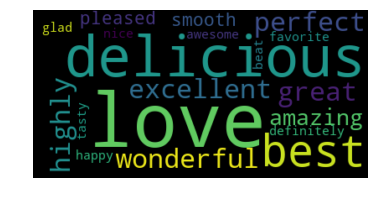

In [47]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt



wordcloud = WordCloud().generate(string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [78]:
sparse_w=clf_1.coef_## getting the coefficients of l1 regularised logistic regreesion
w_l2=clf2.coef_ ## getting coefficients of l2 regularised logistic regression

In [123]:
non_zero=np.count_nonzero(w_l2) ## count of non zero coefficients of l2 regularisation
non_zero1=np.count_nonzero(sparse_w)  ## count of non zero coefficients of l1 regularisation
print('the non_zeros in l2 regularised logistic regression are :',non_zero)
print('the non_zeros in l1 regularised logistic regression are :',non_zero1)


the non_zeros in l2 regularised logistic regression are : 40106
the non_zeros in l1 regularised logistic regression are : 15028


 The non zero coeffcients of l1 regularisation are  less compared to l2 regularisation this shows the l1 regularisation gives more sparse coefficients

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.9444 0.9335 0.8206 0.5    0.5    0.5    0.5    0.5    0.5   ]
the auc score for cv data for each alpha value is :  [0.929  0.9281 0.8233 0.5    0.5    0.5    0.5    0.5    0.5   ]

The optimal alpha is. 1e-05


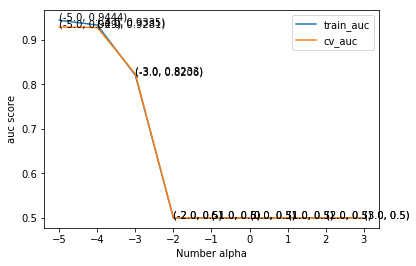

For values of best alpha =  1e-05 The train auc is: 98.43305412973129
For values of best alpha =  1e-05 The cross validation auc is: 94.3203746141548
For values of best alpha =  1e-05 The test  auc is: 94.50608401236326


In [105]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_tfidf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l1', loss='log', random_state=42)
    clf_tfidf.fit(train_tfidf_text,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
    sig_clf.fit(train_tfidf_text, y_tr)
    scores_train = cross_val_score(sig_clf, train_tfidf_text, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, cv_tfidf_text, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
    
    
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


best_alpha = optimal_alpha
clf_tfidf= SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l1', loss='log', random_state=42)### training the model with the best alpha value
clf_tfidf.fit(train_tfidf_text, y_tr)
sig_clf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
sig_clf.fit(train_tfidf_text, y_tr)


predict_y = sig_clf.predict_proba(train_tfidf_text)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(cv_tfidf_text)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(test_tfidf_text)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# ROC curve for train and test data 

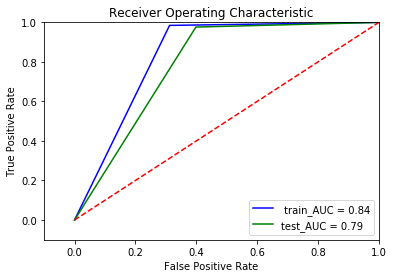

In [106]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l1', loss='log', random_state=42)### training the model with the best alpha value
clf.fit(train_tfidf_text, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf_text, y_tr)


predict_y_train = sig_clf.predict(train_tfidf_text)
predict_y_test = sig_clf.predict(test_tfidf_text)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Confusion matrix for test values

-------------------- Confusion matrix --------------------


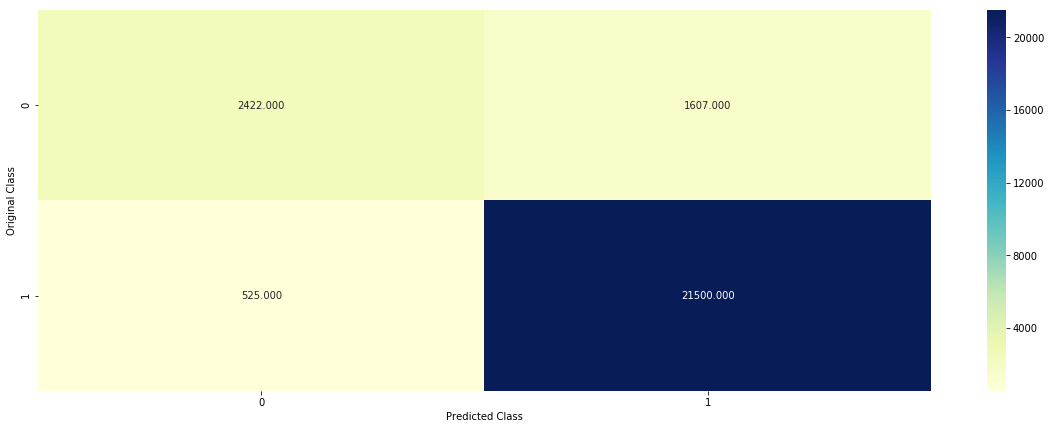

-------------------- Precision matrix (Columm Sum=1) --------------------


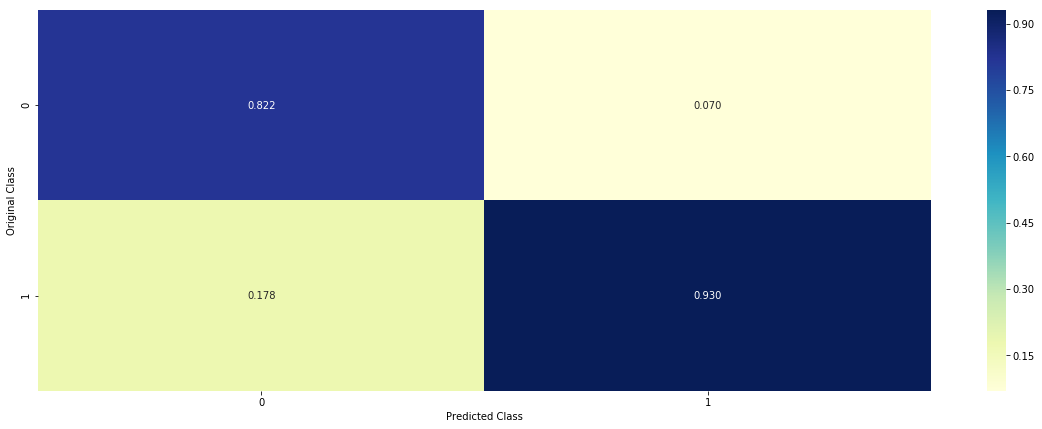

-------------------- Recall matrix (Row sum=1) --------------------


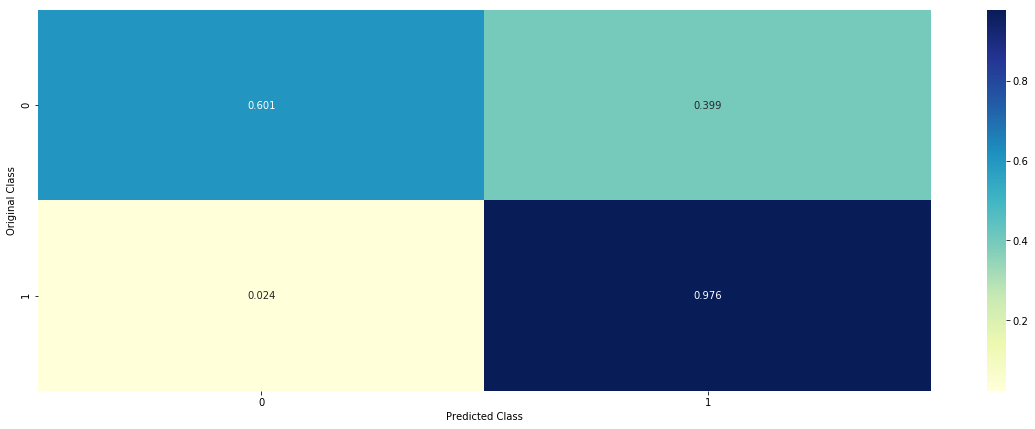

In [85]:
predict_y = sig_clf.predict_proba(test_tfidf_text)
plot_confusion_matrix(y_test, predict_y)

# Confusion matrix for cv values

-------------------- Confusion matrix --------------------


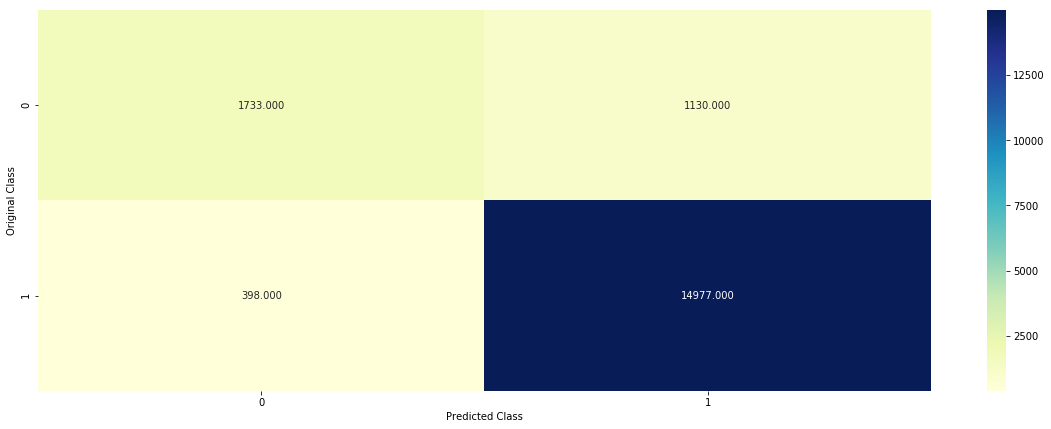

-------------------- Precision matrix (Columm Sum=1) --------------------


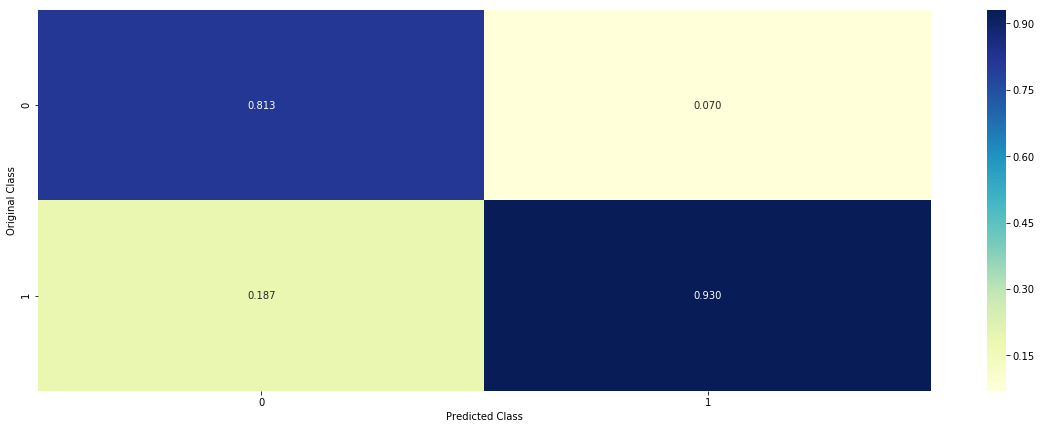

-------------------- Recall matrix (Row sum=1) --------------------


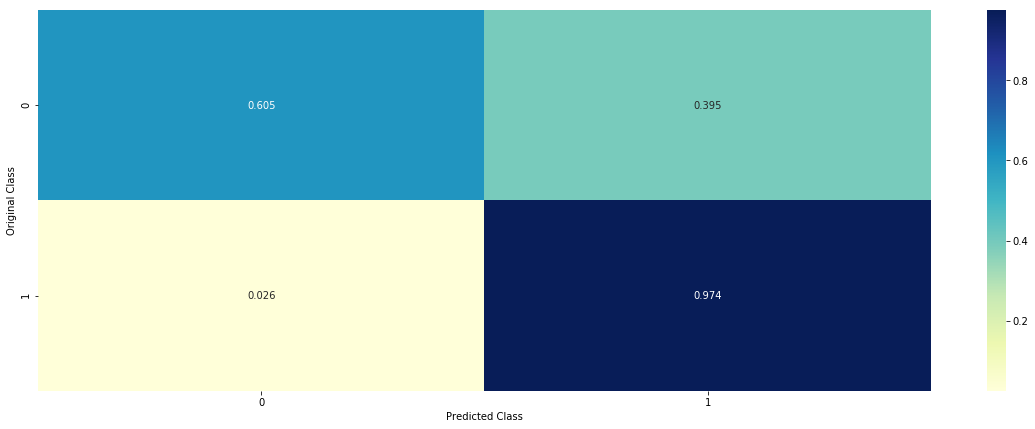

In [86]:
predict_y = sig_clf.predict_proba(cv_tfidf_text)
plot_confusion_matrix(y_cv, predict_y)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.9483 0.9435 0.9216 0.9051 0.9009 0.8996 0.8997 0.8998 0.8999]
the auc score for cv data for each alpha value is :  [0.9348 0.9358 0.9183 0.9034 0.8992 0.898  0.8978 0.8979 0.8979]

The optimal alpha is. 1e-05


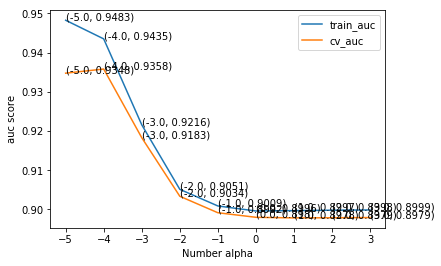

For values of best alpha =  1e-05 The train auc is: 98.71790686245365
For values of best alpha =  1e-05 The cross validation auc is: 94.82032207957428
For values of best alpha =  1e-05 The test  auc is: 94.96750263202452


In [107]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_tfidf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf_tfidf.fit(train_tfidf_text,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
    sig_clf.fit(train_tfidf_text, y_tr)
    scores_train = cross_val_score(sig_clf, train_tfidf_text, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, cv_tfidf_text, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
    
    
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


best_alpha = optimal_alpha
clf_tfidf= SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)### training the model with the best alpha value
clf_tfidf.fit(train_tfidf_text, y_tr)
sig_clf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
sig_clf.fit(train_tfidf_text, y_tr)


predict_y = sig_clf.predict_proba(train_tfidf_text)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(cv_tfidf_text)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(test_tfidf_text)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# ROC curve for train and test data

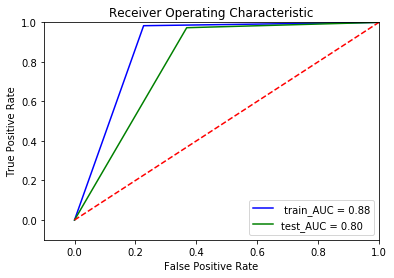

In [108]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)### training the model with the best alpha value
clf.fit(train_tfidf_text, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf_text, y_tr)


predict_y_train = sig_clf.predict(train_tfidf_text)
predict_y_test = sig_clf.predict(test_tfidf_text)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Confusion matrix for test values

-------------------- Confusion matrix --------------------


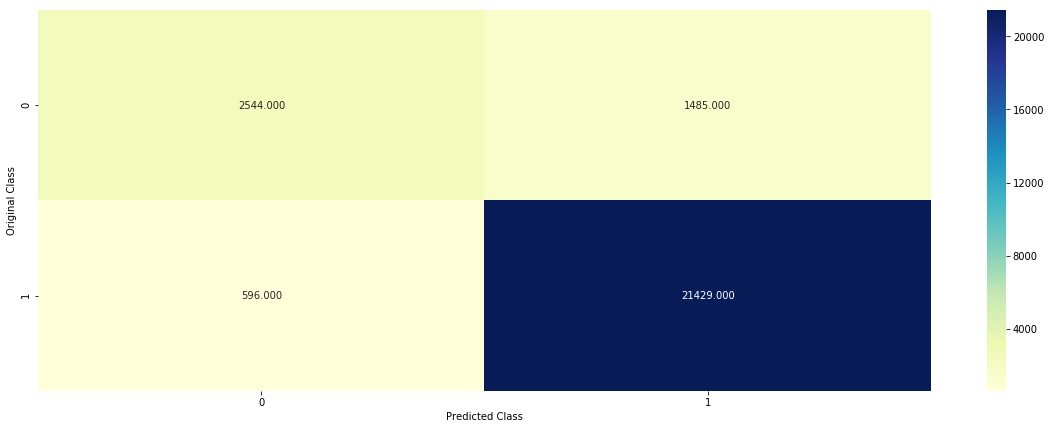

-------------------- Precision matrix (Columm Sum=1) --------------------


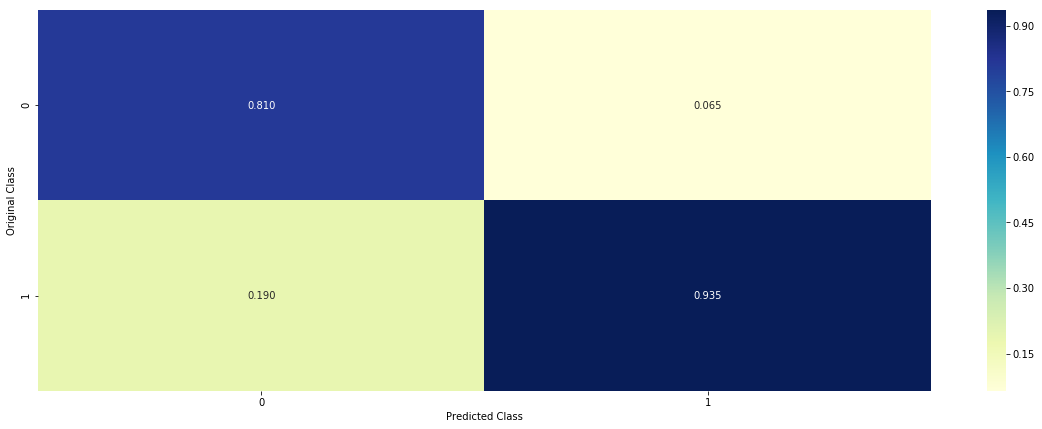

-------------------- Recall matrix (Row sum=1) --------------------


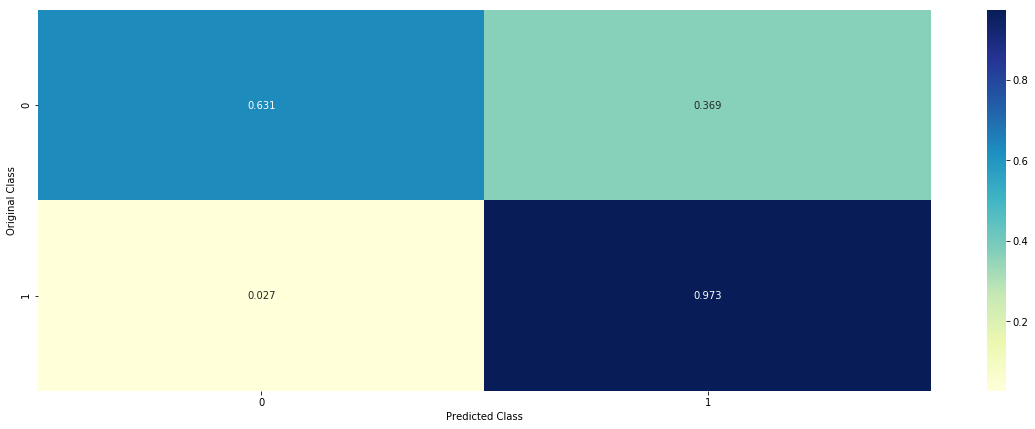

In [88]:
predict_y = sig_clf.predict_proba(test_tfidf_text)
plot_confusion_matrix(y_test, predict_y)

# Confusion matrix for cv values

-------------------- Confusion matrix --------------------


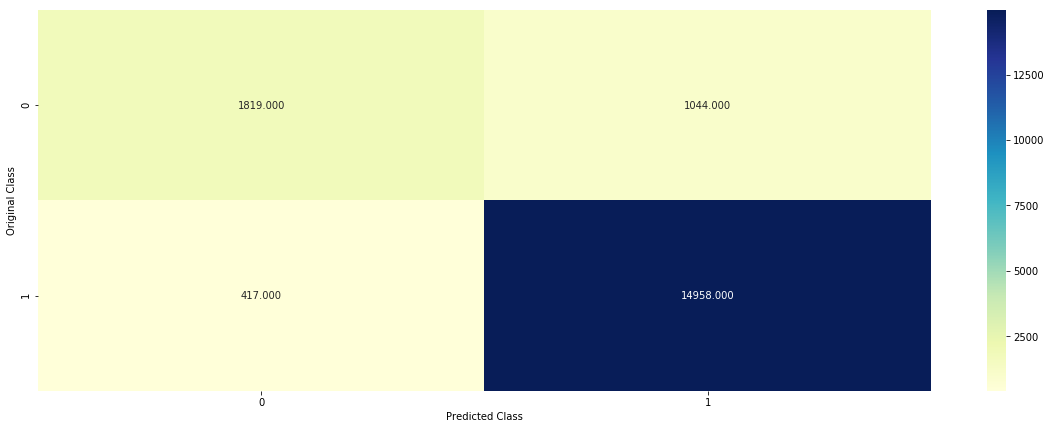

-------------------- Precision matrix (Columm Sum=1) --------------------


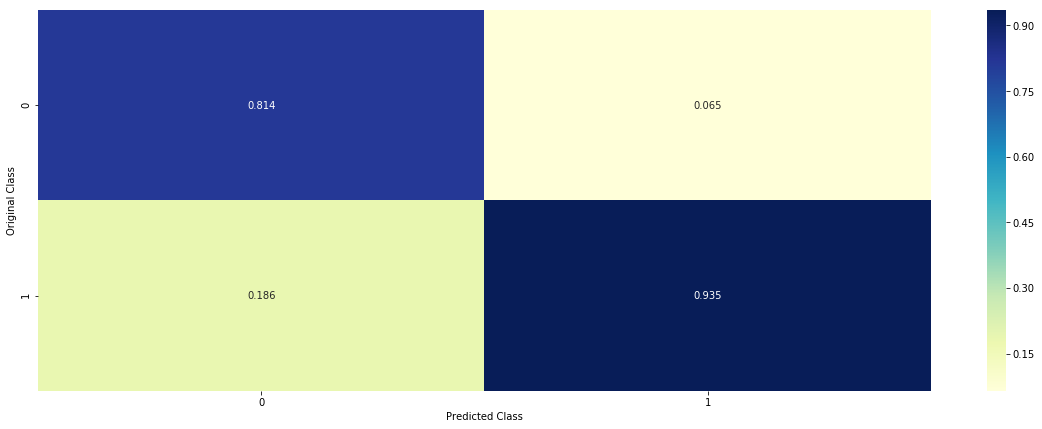

-------------------- Recall matrix (Row sum=1) --------------------


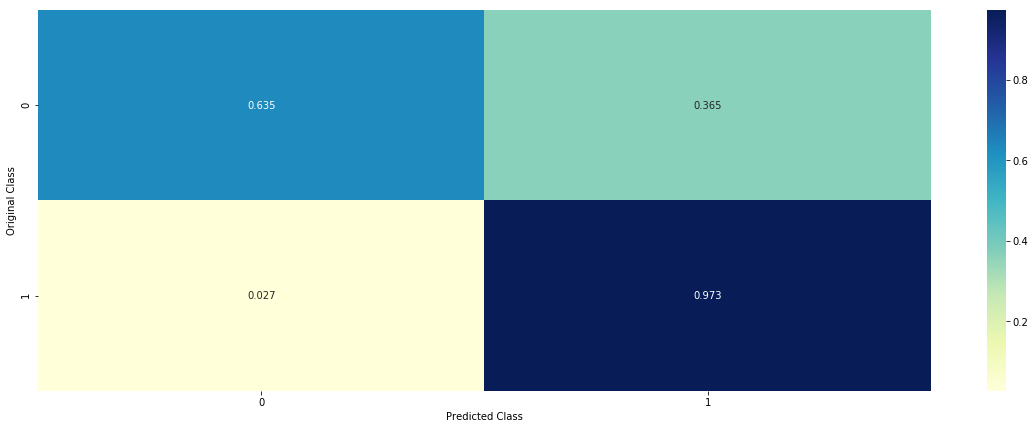

In [89]:
predict_y = sig_clf.predict(cv_tfidf_text)
plot_confusion_matrix(y_cv, predict_y)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [90]:
# Please write all the code with proper documentation
coef = clf_tfidf.coef_.ravel()
features=tf_idf_vect.get_feature_names()
topn_features0 = sorted(zip(coef, features),reverse=True)[:20]
topn_features1 = sorted(zip(coef, features))[:20]
print('***** positive features********')
for coef,features in topn_features0:
    print("value : %d   feature: %s" %(coef,features))

***** positive features********
value : 13   feature: great
value : 10   feature: best
value : 10   feature: perfect
value : 9   feature: delicious
value : 8   feature: excellent
value : 7   feature: good
value : 7   feature: love
value : 7   feature: wonderful
value : 7   feature: loves
value : 7   feature: highly
value : 7   feature: amazing
value : 7   feature: pleased
value : 6   feature: happy
value : 5   feature: favorite
value : 5   feature: definitely
value : 5   feature: glad
value : 5   feature: beat
value : 5   feature: easy
value : 5   feature: exactly
value : 5   feature: smooth


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [91]:
# Please write all the code with proper documentation
print('***** neagative features********')
for coef,features in topn_features1:
    print("value : %d   feature: %s" %(coef,features))


***** neagative features********
value : -9   feature: disappointing
value : -8   feature: awful
value : -8   feature: worst
value : -8   feature: not
value : -7   feature: disappointed
value : -7   feature: terrible
value : -7   feature: disappointment
value : -6   feature: horrible
value : -6   feature: gross
value : -6   feature: unfortunately
value : -5   feature: tasteless
value : -5   feature: disgusting
value : -5   feature: nasty
value : -5   feature: stale
value : -5   feature: excited
value : -5   feature: poor
value : -5   feature: rip
value : -5   feature: worse
value : -5   feature: weak
value : -5   feature: thought


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.8753 0.8936 0.8948 0.8747 0.5    0.5    0.5    0.5    0.5   ]
the auc score for cv data for each alpha value is :  [0.8772 0.889  0.8944 0.8724 0.5    0.5    0.5    0.5    0.5   ]

The optimal alpha is. 0.001


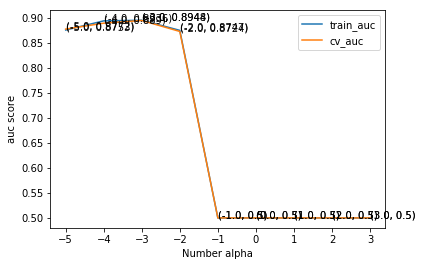

For values of best alpha =  0.001 The train auc is: 89.59727931529966
For values of best alpha =  0.001 The cross validation auc is: 89.52002930577682
For values of best alpha =  0.001 The test  auc is: 89.60720474629312


In [109]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_word = SGDClassifier( class_weight='balanced', alpha=i, penalty='l1', loss='log', random_state=42)
    clf_word.fit(sent_vectors,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
    sig_clf.fit(sent_vectors,  y_tr)
    scores_train = cross_val_score(sig_clf, sent_vectors,  y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
    
    
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


best_alpha = optimal_alpha
clf_word= SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l1', loss='log', random_state=42)### training the model with the best alpha value
clf_word.fit(sent_vectors, y_tr)
sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
sig_clf.fit(sent_vectors,  y_tr)


predict_y = sig_clf.predict_proba(sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# ROC curve for train and test data 

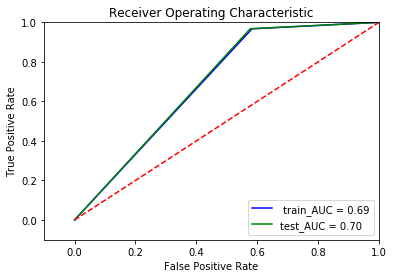

In [110]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf_word=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l1', loss='log', random_state=42)
clf_word.fit(sent_vectors, y_tr)
sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
sig_clf.fit(sent_vectors, y_tr)


predict_y_train =  sig_clf.predict(sent_vectors)
predict_y_test =sig_clf.predict(sent_vectors_test)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Confusion matrix for test values

-------------------- Confusion matrix --------------------


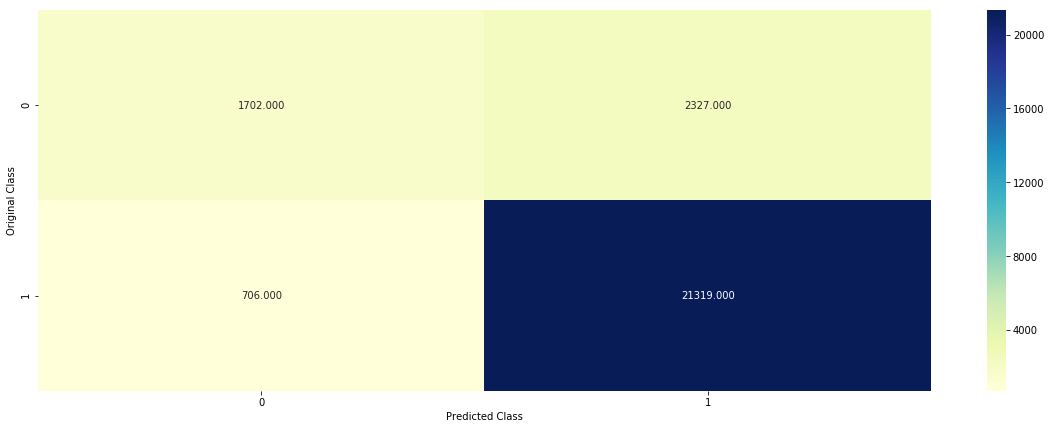

-------------------- Precision matrix (Columm Sum=1) --------------------


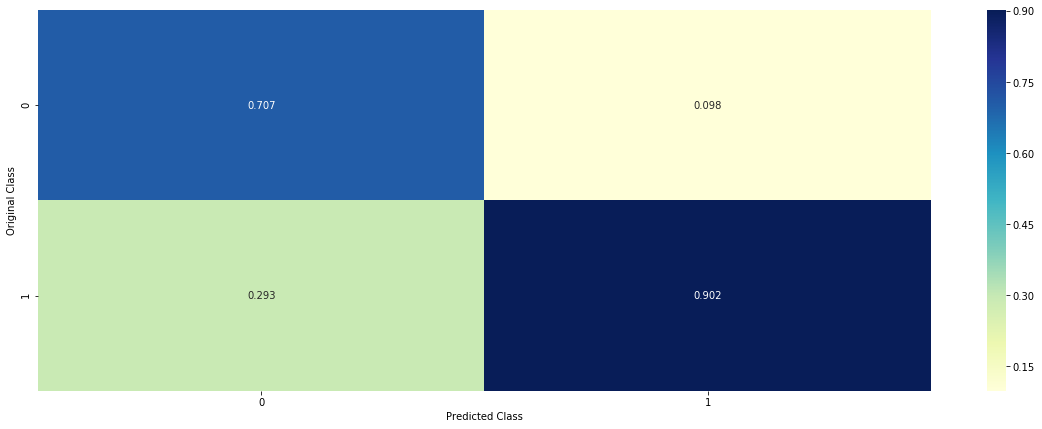

-------------------- Recall matrix (Row sum=1) --------------------


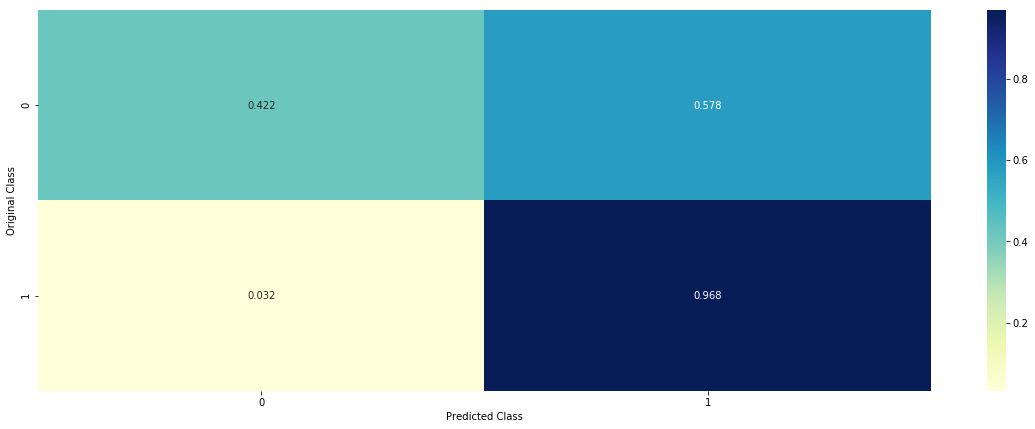

In [93]:

predict_y = sig_clf.predict(sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

# Confusion matrix for cv values

-------------------- Confusion matrix --------------------


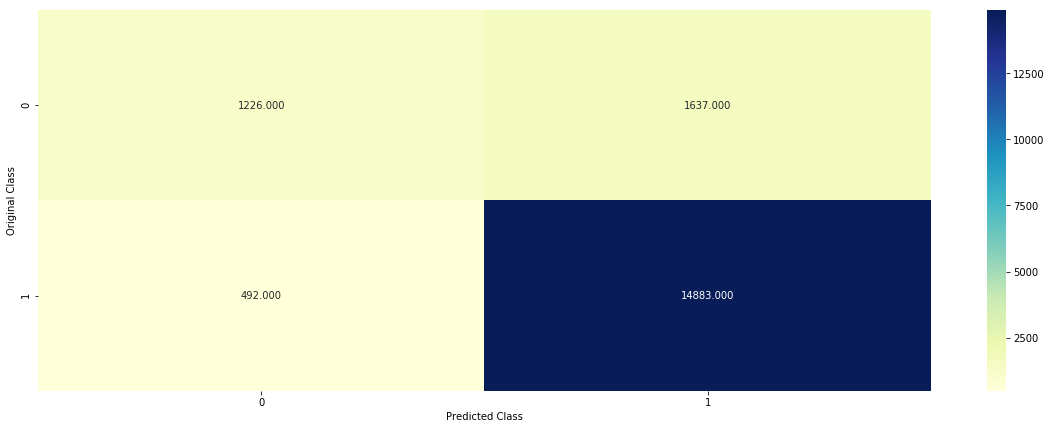

-------------------- Precision matrix (Columm Sum=1) --------------------


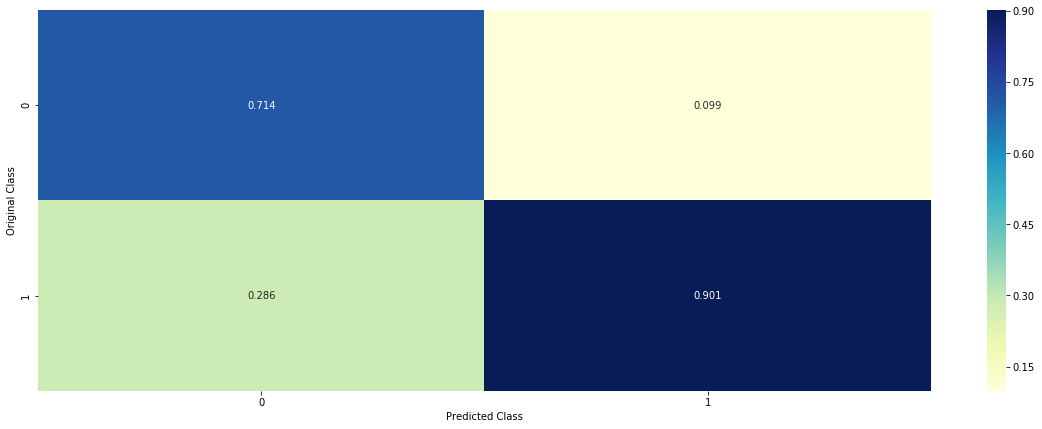

-------------------- Recall matrix (Row sum=1) --------------------


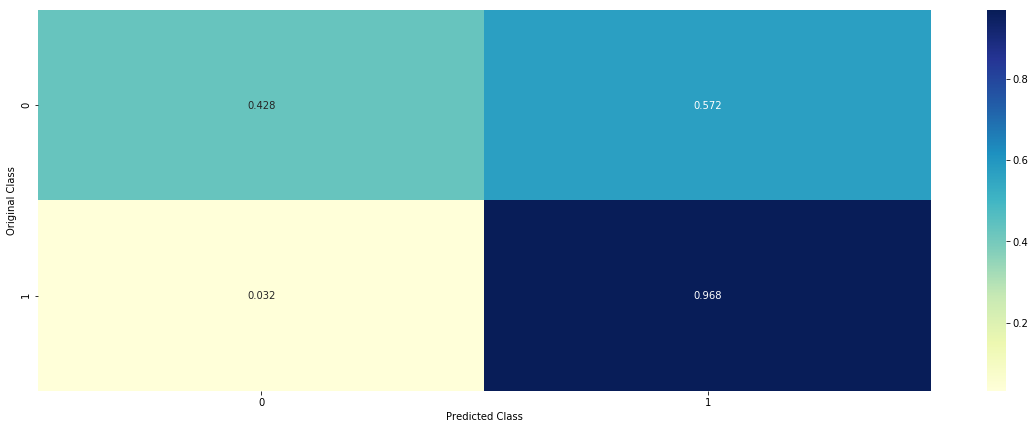

In [94]:

predict_y = sig_clf.predict(sent_vectors_cv)
plot_confusion_matrix(y_cv, predict_y)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.881  0.8922 0.896  0.8926 0.8854 0.8738 0.8676 0.8684 0.8693]
the auc score for cv data for each alpha value is :  [0.8758 0.8839 0.8955 0.8927 0.8853 0.8684 0.8677 0.8675 0.8678]

The optimal alpha is. 0.001


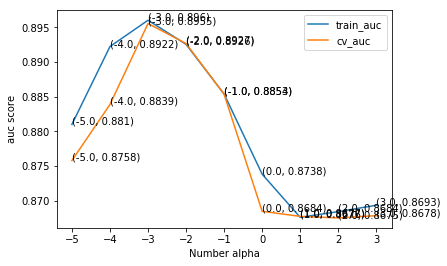

For values of best alpha =  0.001 The train auc is: 89.7117242947512
For values of best alpha =  0.001 The cross validation auc is: 89.6094573603787
For values of best alpha =  0.001 The test  auc is: 89.68763186534403


In [111]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_word = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf_word.fit(sent_vectors,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
    sig_clf.fit(sent_vectors,  y_tr)
    scores_train = cross_val_score(sig_clf, sent_vectors,  y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
    
    
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


best_alpha = optimal_alpha
clf_word= SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)### training the model with the best alpha value
clf_word.fit(sent_vectors,  y_tr)
sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
sig_clf.fit(sent_vectors,  y_tr)


predict_y = sig_clf.predict_proba(sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# ROC curve for train and test data 

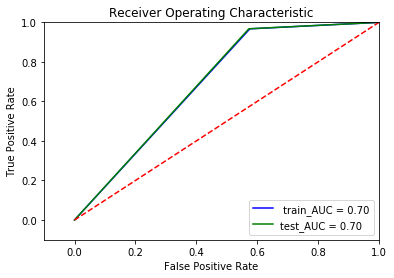

In [112]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf_word=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf_word.fit(sent_vectors, y_tr)
sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
sig_clf.fit(sent_vectors, y_tr)


predict_y_train =  sig_clf.predict(sent_vectors)
predict_y_test =sig_clf.predict(sent_vectors_test)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Confusion matrix for test values

-------------------- Confusion matrix --------------------


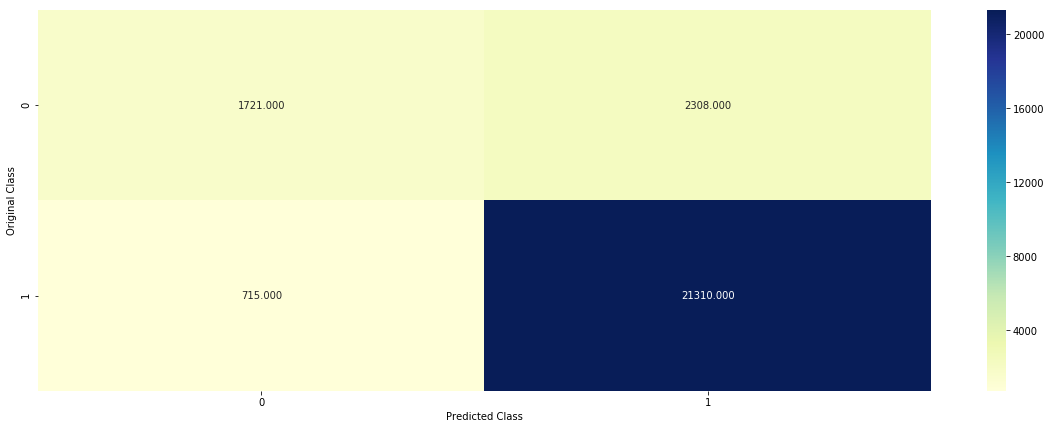

-------------------- Precision matrix (Columm Sum=1) --------------------


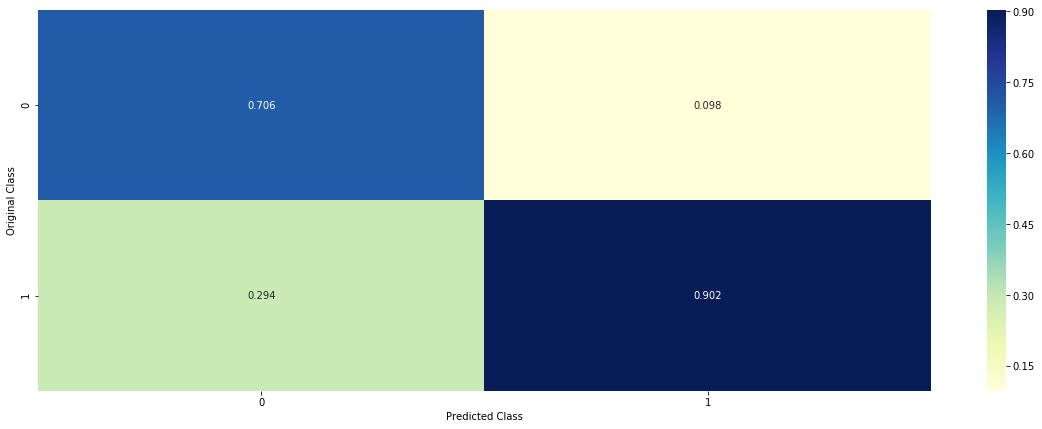

-------------------- Recall matrix (Row sum=1) --------------------


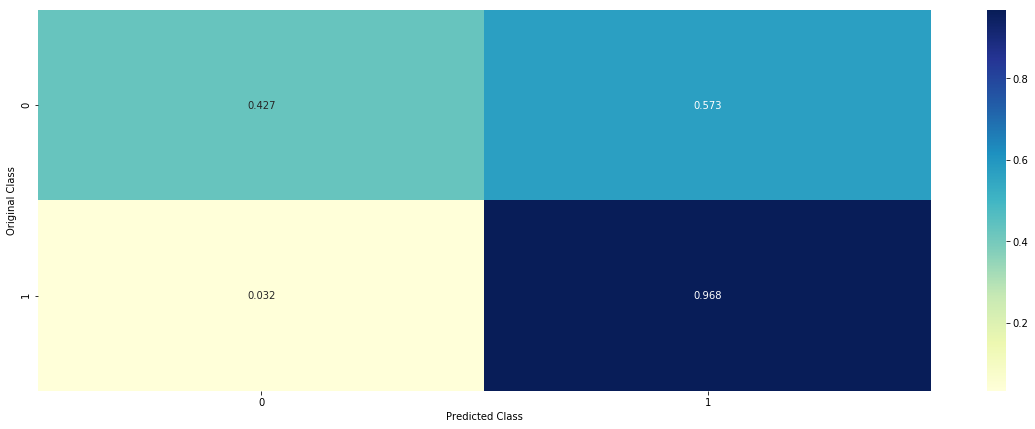

In [96]:

predict_y = sig_clf.predict(sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

# Confusion matrix for cv values

-------------------- Confusion matrix --------------------


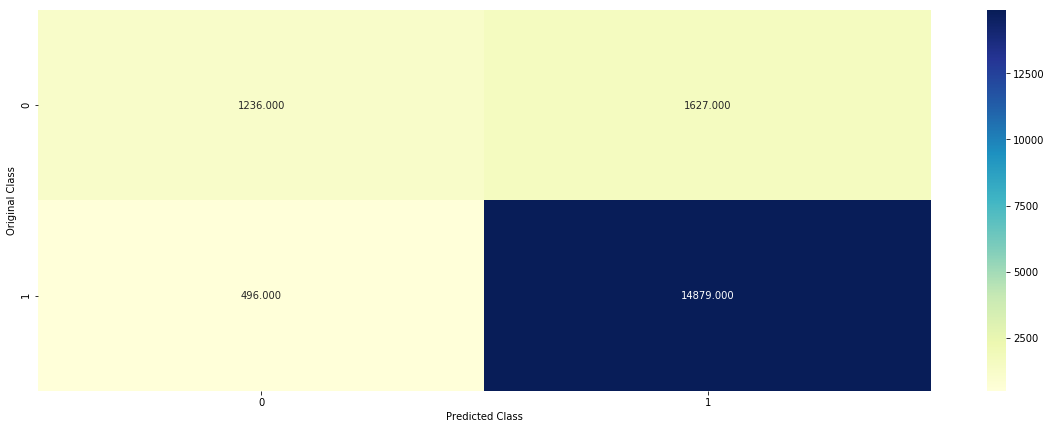

-------------------- Precision matrix (Columm Sum=1) --------------------


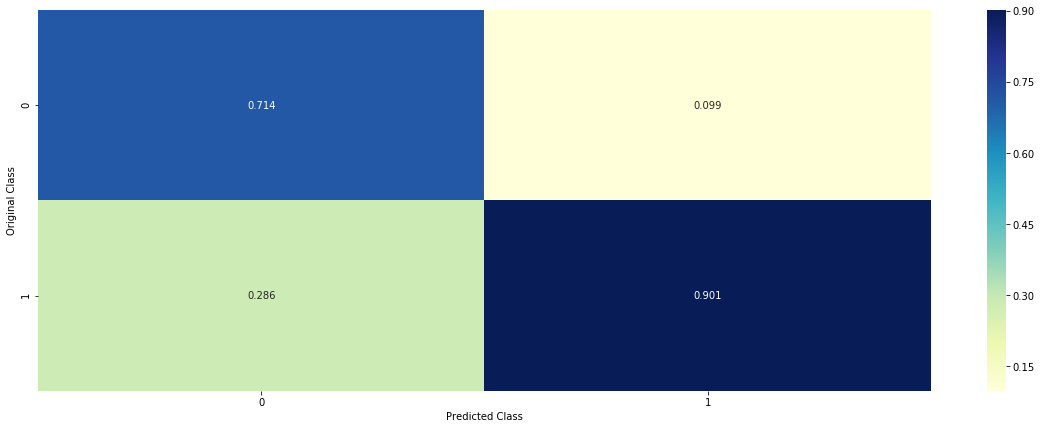

-------------------- Recall matrix (Row sum=1) --------------------


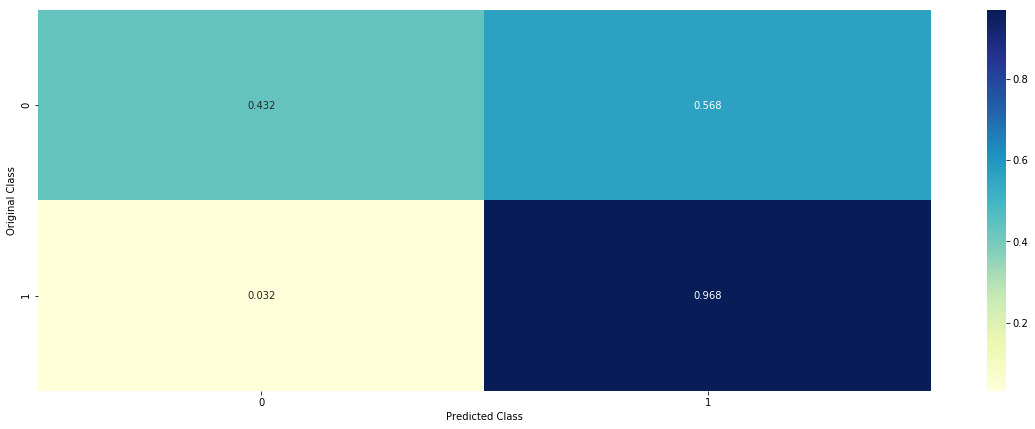

In [97]:

predict_y = sig_clf.predict(sent_vectors_cv)
plot_confusion_matrix(y_cv, predict_y)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.8425 0.864  0.8704 0.8474 0.5    0.5    0.5    0.5    0.5   ]
the auc score for cv data for each alpha value is :  [0.8393 0.8556 0.8691 0.8448 0.5    0.5    0.5    0.5    0.5   ]

The optimal alpha is. 0.001


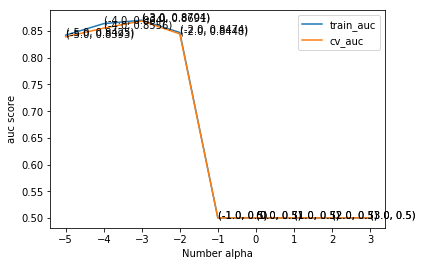

For values of best alpha =  0.001 The train auc is: 86.90283715154489
For values of best alpha =  0.001 The cross validation auc is: 86.7197487427197
For values of best alpha =  0.001 The test  auc is: 86.91527289804985


In [113]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_word_tfidf =  SGDClassifier( class_weight='balanced', alpha=i, penalty='l1', loss='log', random_state=42)
    clf_word_tfidf.fit(tfidf_sent_vectors,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
    sig_clf.fit(tfidf_sent_vectors,  y_tr)
    scores_train = cross_val_score(sig_clf, tfidf_sent_vectors,  y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, tfidf_sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
    
    
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


best_alpha = optimal_alpha
clf_word_tfidf= SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l1', loss='log', random_state=42)### training the model with the best alpha value
clf_word_tfidf.fit(sent_vectors,  y_tr)
sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
sig_clf.fit(sent_vectors,  y_tr)


predict_y = sig_clf.predict_proba(tfidf_sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(tfidf_sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# ROC curve for train and test data 

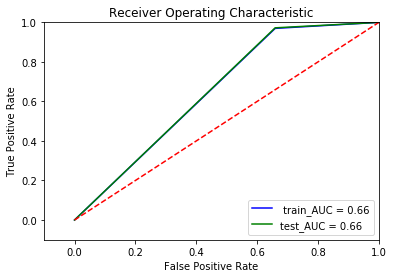

In [114]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

best_alpha = optimal_alpha
clf_word_tfidf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l1', loss='log', random_state=42)
clf_word_tfidf.fit(tfidf_sent_vectors, y_tr)
sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors, y_tr)


predict_y_train =  sig_clf.predict(tfidf_sent_vectors)
predict_y_test =sig_clf.predict(tfidf_sent_vectors_test)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Confusion matrix for test values

-------------------- Confusion matrix --------------------


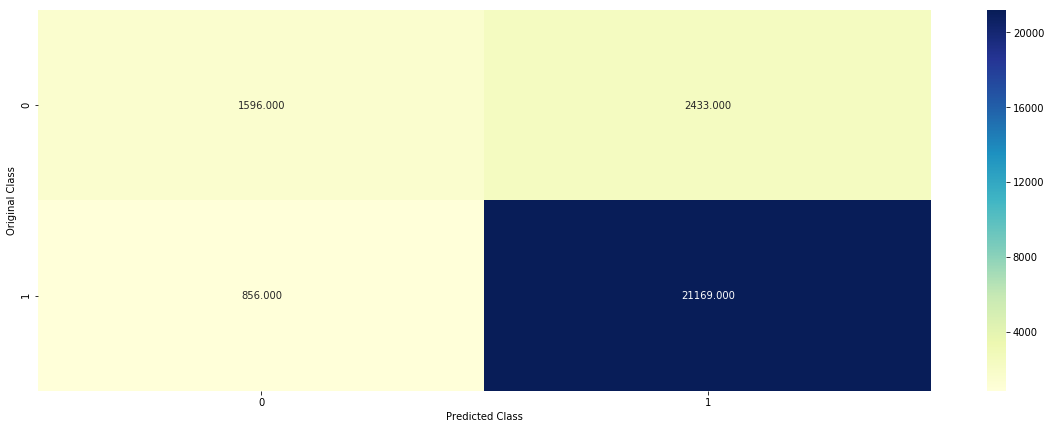

-------------------- Precision matrix (Columm Sum=1) --------------------


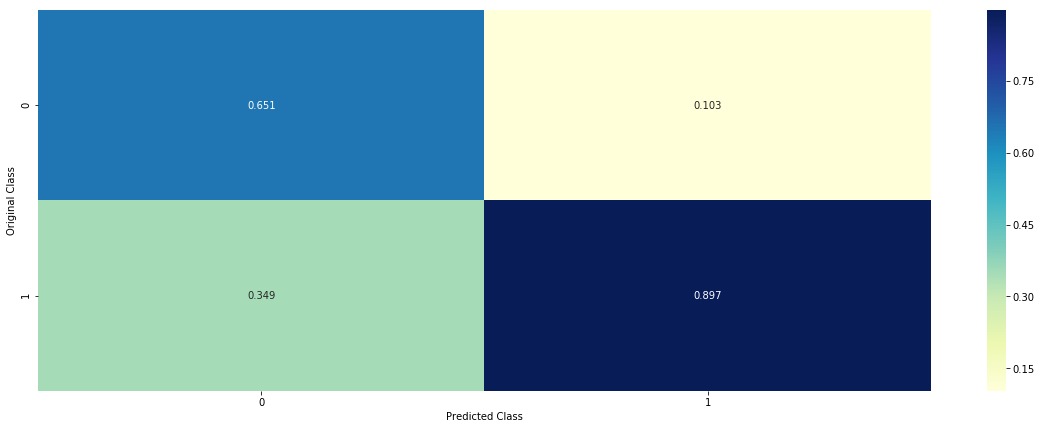

-------------------- Recall matrix (Row sum=1) --------------------


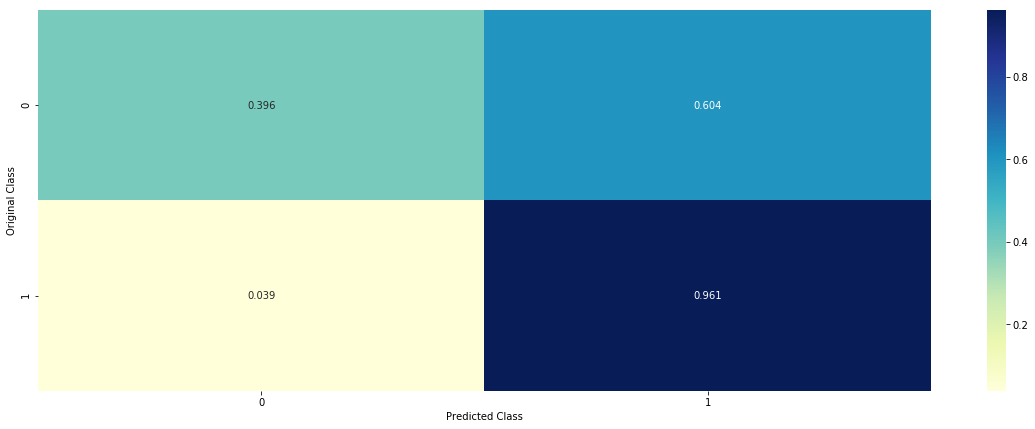

In [99]:


predict_y = sig_clf.predict(tfidf_sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

# Confusion matrix for cv values

-------------------- Confusion matrix --------------------


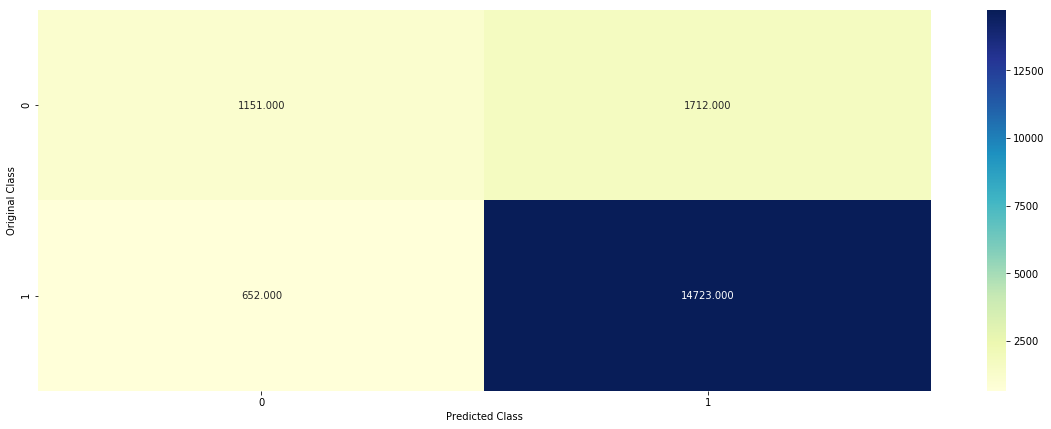

-------------------- Precision matrix (Columm Sum=1) --------------------


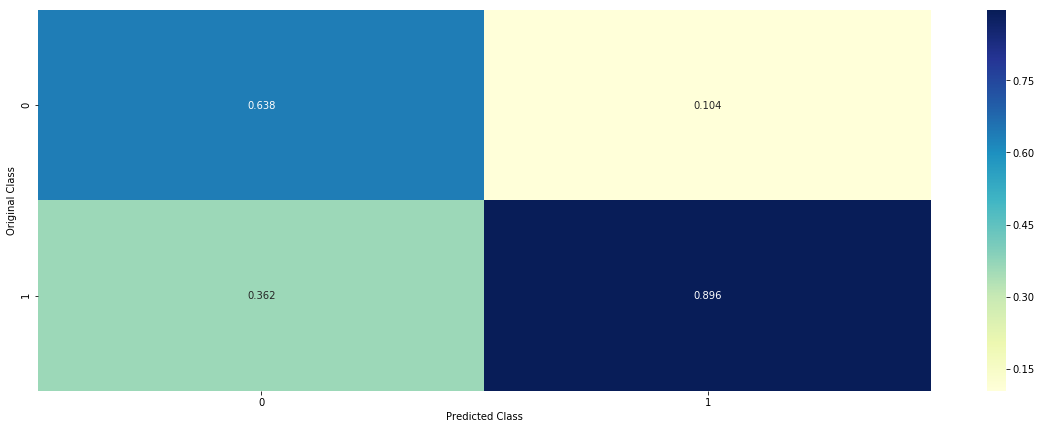

-------------------- Recall matrix (Row sum=1) --------------------


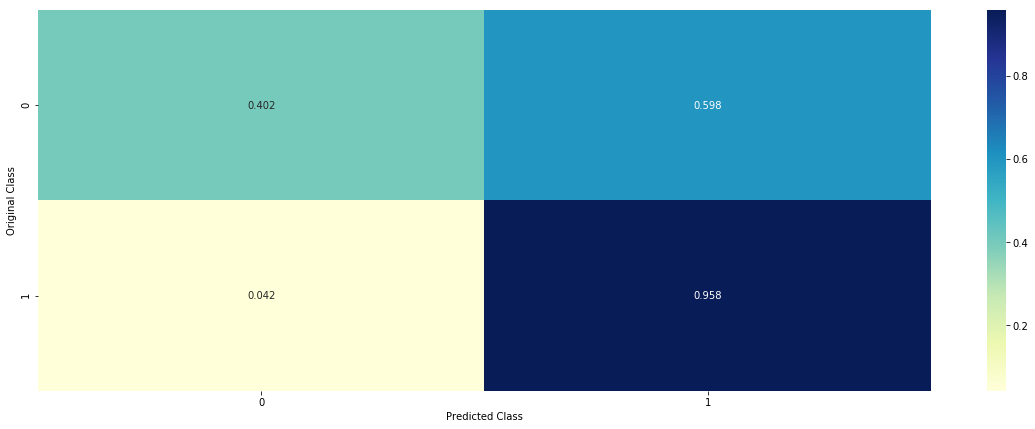

In [100]:


predict_y = sig_clf.predict(tfidf_sent_vectors_cv)
plot_confusion_matrix(y_cv, predict_y)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.8395 0.861  0.8714 0.8672 0.8575 0.8411 0.8332 0.8334 0.8337]
the auc score for cv data for each alpha value is :  [0.8379 0.8467 0.8703 0.8675 0.8576 0.8363 0.8324 0.8323 0.832 ]

The optimal alpha is. 0.001


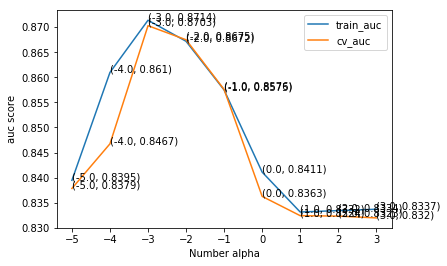

For values of best alpha =  0.001 The train auc is: 87.0073645014181
For values of best alpha =  0.001 The cross validation auc is: 86.82006764182206
For values of best alpha =  0.001 The test  auc is: 86.9911405646182


In [115]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_word_tfidf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf_word_tfidf.fit(tfidf_sent_vectors,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
    sig_clf.fit(tfidf_sent_vectors,  y_tr)
    scores_train = cross_val_score(sig_clf, tfidf_sent_vectors,  y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, tfidf_sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
    
    
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


best_alpha = optimal_alpha
clf_word_tfidf= SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)### training the model with the best alpha value
clf_word_tfidf.fit(sent_vectors,  y_tr)
sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
sig_clf.fit(sent_vectors,  y_tr)


predict_y = sig_clf.predict_proba(tfidf_sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(tfidf_sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# ROC curve for train and test data 

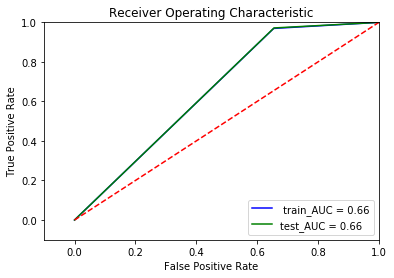

In [116]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

best_alpha = optimal_alpha
clf_word_tfidf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf_word_tfidf.fit(tfidf_sent_vectors, y_tr)
sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors, y_tr)


predict_y_train =  sig_clf.predict(tfidf_sent_vectors)
predict_y_test =sig_clf.predict(tfidf_sent_vectors_test)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Confusion matrix for test values

-------------------- Confusion matrix --------------------


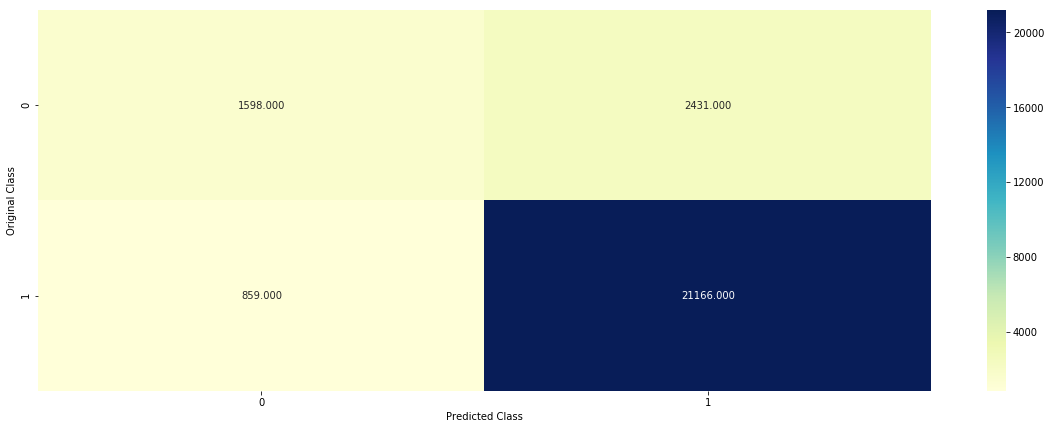

-------------------- Precision matrix (Columm Sum=1) --------------------


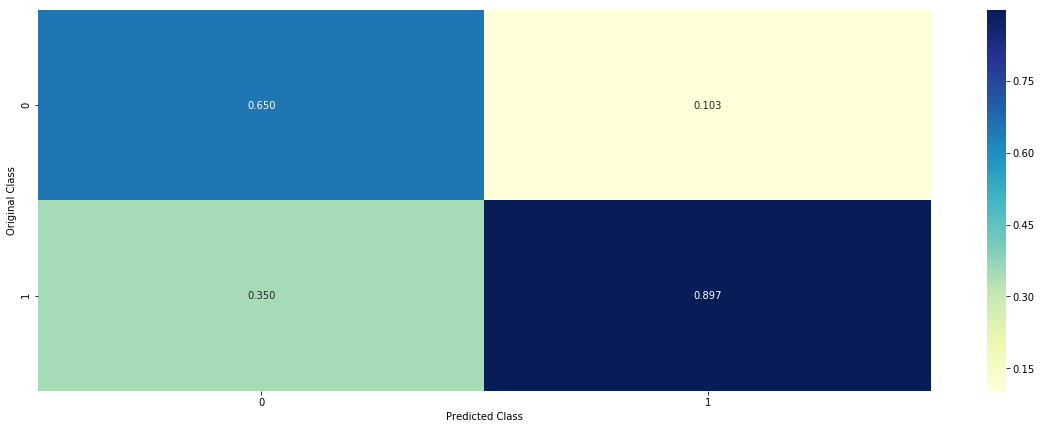

-------------------- Recall matrix (Row sum=1) --------------------


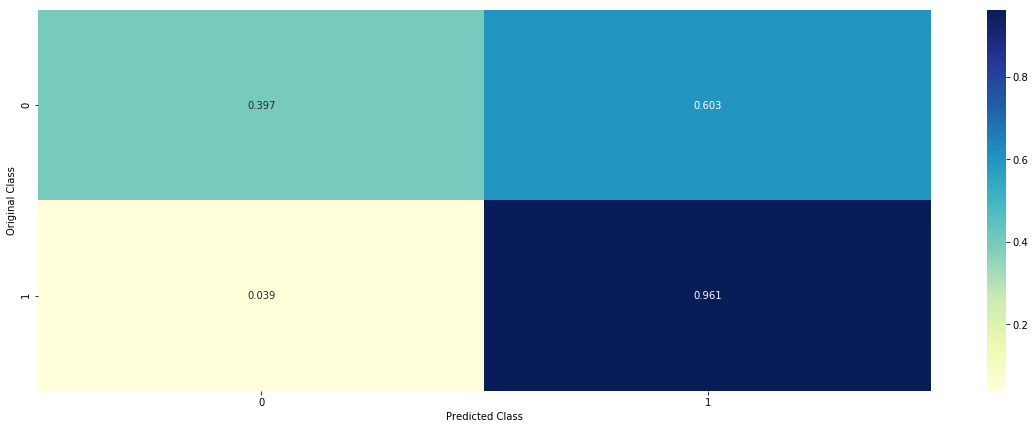

In [82]:


predict_y = sig_clf.predict(tfidf_sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

# Confusion matrix for cv values

-------------------- Confusion matrix --------------------


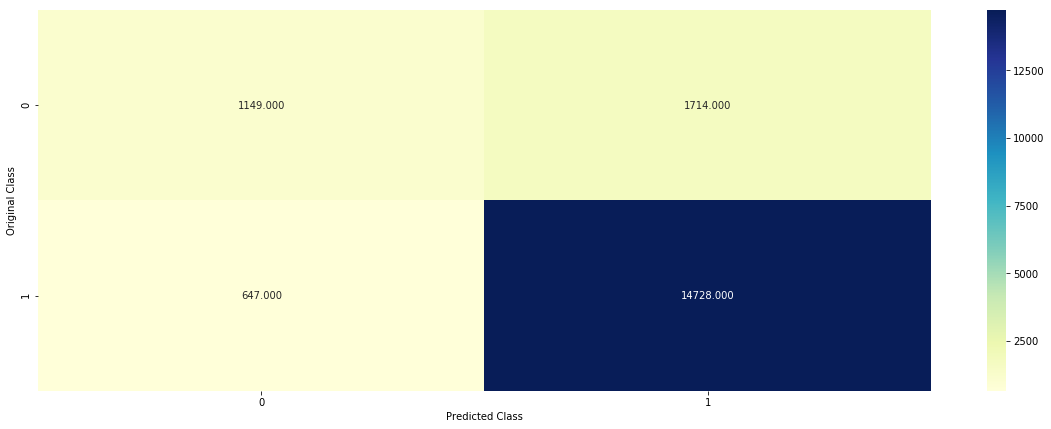

-------------------- Precision matrix (Columm Sum=1) --------------------


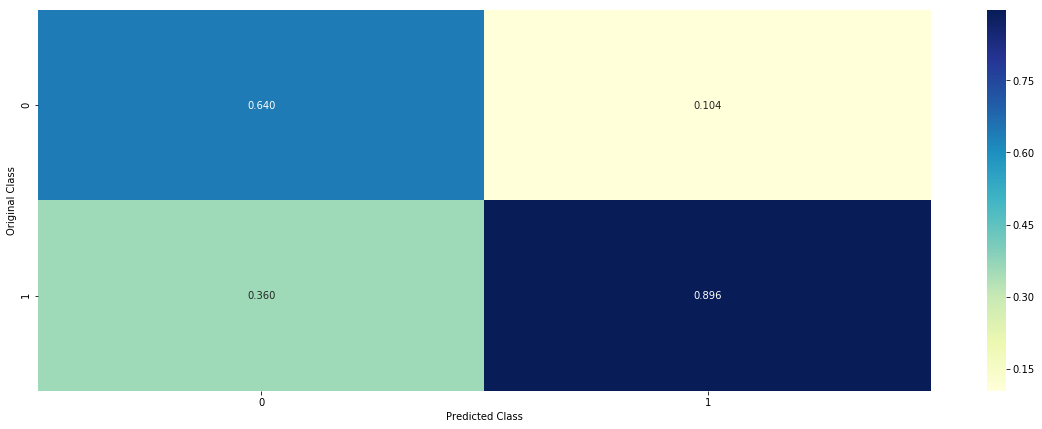

-------------------- Recall matrix (Row sum=1) --------------------


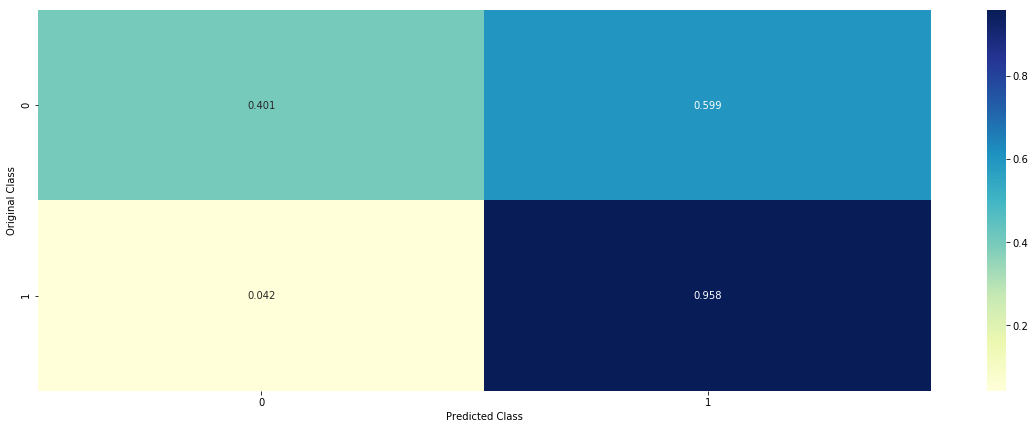

In [83]:


predict_y = sig_clf.predict(tfidf_sent_vectors_cv)
plot_confusion_matrix(y_cv, predict_y)

# [6] Conclusions

In [124]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC_train","AUC_CV","AUC_test"]
x.add_row(["BOW", "l1-regularised",1e-05 ,97.36473098973258,92.85366137629242,  92.90528007924387])
x.add_row(["BOW", "l2-regularised",0.001 ,96.43467641631166, 93.27025548844381 ,93.29625143926737])
x.add_row(["TF-IDF", "l1-regularised", 1e-05, 98.43305412973129, 94.3203746141548,94.50608401236326])
x.add_row(["TF-IDF", "l2-regularised",  1e-05, 98.71790686245365,94.82032207957428,94.96750263202452])
x.add_row(["AVG-word 2vec", "l1-regularised", 0.001,89.59727931529966,89.52002930577682,89.60720474629312])
x.add_row(["AVG-word 2vec", "l2-regularised", 0.001,89.7117242947512,89.6094573603787,89.68763186534403])

x.add_row([" TFIDF W2v", "l1-regularised", 0.001,86.90283715154489,86.7197487427197,86.91527289804985])
x.add_row([" TFIDF W2v", "l2-regularised", 0.001,87.0073645014181,86.82006764182206, 86.9911405646182])


print(x)
 
 


+---------------+----------------+----------------+-------------------+-------------------+-------------------+
|   Vectorizer  |     Model      | Hyperparameter |     AUC_train     |       AUC_CV      |      AUC_test     |
+---------------+----------------+----------------+-------------------+-------------------+-------------------+
|      BOW      | l1-regularised |     1e-05      | 97.36473098973258 | 92.85366137629242 | 92.90528007924387 |
|      BOW      | l2-regularised |     0.001      | 96.43467641631166 | 93.27025548844381 | 93.29625143926737 |
|     TF-IDF    | l1-regularised |     1e-05      | 98.43305412973129 |  94.3203746141548 | 94.50608401236326 |
|     TF-IDF    | l2-regularised |     1e-05      | 98.71790686245365 | 94.82032207957428 | 94.96750263202452 |
| AVG-word 2vec | l1-regularised |     0.001      | 89.59727931529966 | 89.52002930577682 | 89.60720474629312 |
| AVG-word 2vec | l2-regularised |     0.001      |  89.7117242947512 |  89.6094573603787 | 89.687631865